In [1]:
"""
Hybrid EEG Foundation Model - Data Exploration Script for Google Colab
====================================================================

This script combines the power of standard libraries (eegdash, braindecode) with
custom analysis capabilities for comprehensive EEG data exploration.

Libraries Used:
- eegdash: Competition data loading and caching
- braindecode: EEG-specific preprocessing and model utilities
- MNE: Advanced signal processing and visualization
- Custom: Our specialized analysis and gentle preprocessing

Usage in Google Colab:
1. Mount Google Drive
2. Install required packages
3. Run sections sequentially for comprehensive EDA

Author: Adolfo Ramirez-Aristizabal
"""

'\nHybrid EEG Foundation Model - Data Exploration Script for Google Colab\n====================================================================\n\nThis script combines the power of standard libraries (eegdash, braindecode) with\ncustom analysis capabilities for comprehensive EEG data exploration.\n\nLibraries Used:\n- eegdash: Competition data loading and caching\n- braindecode: EEG-specific preprocessing and model utilities\n- MNE: Advanced signal processing and visualization\n- Custom: Our specialized analysis and gentle preprocessing\n\nUsage in Google Colab:\n1. Mount Google Drive\n2. Install required packages\n3. Run sections sequentially for comprehensive EDA\n\nAuthor: Adolfo Ramirez-Aristizabal\n'

# SECTION 1: SETUP AND INSTALLATION (Google Colab)

In [2]:
# Install competition-specific packages for Google Colab

!pip install eegdash braindecode mne>=1.6.0 plotly>=5.17.0 einops>=0.7.0


# Mount Google Drive (uncomment for Colab)
"""
from google.colab import drive
drive.mount('/content/drive')

# Navigate to project directory (adjust path as needed)
import os
project_path = '/content/drive/My Drive/My_Path/'
os.chdir(project_path)
print(f"Current directory: {os.getcwd()}")
"""

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Navigate to project directory (adjust path as needed)\nimport os\nproject_path = \'/content/drive/My Drive/My_Path/\'\nos.chdir(project_path)\nprint(f"Current directory: {os.getcwd()}")\n'

# SECTION 2: IMPORT LIBRARIES

In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Competition libraries
from eegdash.dataset import EEGChallengeDataset
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from braindecode.datasets import BaseConcatDataset
from braindecode.models import EEGNeX

# EEG processing
import mne
from scipy import signal
from scipy.stats import pearsonr, entropy

# Deep learning utilities
import torch
from torch.utils.data import DataLoader
from einops import rearrange, reduce

# Configure plotting and MNE
plt.style.use('default')
sns.set_palette("husl")
mne.set_log_level('WARNING')

print("All libraries imported successfully!")
print("Ready for hybrid EEG analysis with standard + custom capabilities")

All libraries imported successfully!
Ready for hybrid EEG analysis with standard + custom capabilities


# SECTION 3: DATA LOADING WITH EEGDASH

In [4]:
def load_competition_data(task="contrastChangeDetection", release="R5", mini=True, cache_dir="./data"):
    """
    Load competition data using eegdash library

    Parameters:
    - task: Competition task name
    - release: Data release (R5 for validation, others for training)
    - mini: True for small subset, False for full dataset
    - cache_dir: Local caching directory
    """
    print("Loading Competition Data with EEGDash")
    print("=" * 60)

    try:
        # Load dataset
        print(f"Loading task: {task}, release: {release}, mini: {mini}")
        dataset = EEGChallengeDataset(
            task=task,
            release=release,
            cache_dir=cache_dir,
            mini=mini
        )

        print(f"Dataset loaded successfully!")
        print(f"Total recordings: {len(dataset.datasets)}")
        print(f"Cache directory: {cache_dir}")

        # Inspect first recording
        first_recording = dataset.datasets[0]
        raw = first_recording.raw

        print(f"\nFirst Recording Summary:")
        print(f"  Channels: {raw.info['nchan']}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  Duration: {raw.times[-1]:.1f} seconds")
        print(f"  Data shape: {raw.get_data().shape}")

        return dataset, raw

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Tip: Ensure internet connection for initial download")
        return None, None

def inspect_dataset_structure(dataset):
    """Inspect the structure of loaded dataset"""
    print("\nDATASET STRUCTURE INSPECTION")
    print("-" * 40)

    for i, ds in enumerate(dataset.datasets[:3]):  # First 3 recordings
        raw = ds.raw
        print(f"\nRecording {i+1}:")
        print(f"  Subject: {getattr(ds, 'subject', 'Unknown')}")
        print(f"  Session: {getattr(ds, 'session', 'Unknown')}")
        print(f"  Channels: {raw.info['nchan']}")
        print(f"  Duration: {raw.times[-1]:.1f}s")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")
        print(f"  Channel names (first 10): {raw.ch_names[:10]}")

        # Check for events/annotations
        if hasattr(raw, 'annotations') and len(raw.annotations) > 0:
            print(f"  Annotations: {len(raw.annotations)} events")
            unique_descriptions = list(set(raw.annotations.description))
            print(f"  Event types: {unique_descriptions[:5]}")  # First 5 types

# SECTION 4: BRAINDECODE PREPROCESSING PIPELINE

In [5]:
def select_sampling_frequency(original_sfreq=500):
    """
    Interactive sampling frequency selection with recommendations

    Parameters:
    - original_sfreq: Original sampling frequency of the data

    Returns:
    - target_sfreq: Selected target sampling frequency
    """
    print("\n" + "="*70)
    print("SAMPLING FREQUENCY SELECTION")
    print("="*70)

    print(f"Original data sampling rate: {original_sfreq} Hz")
    print(f"Maximum detectable frequency (Nyquist): {original_sfreq/2} Hz")

    # Provide options with recommendations
    options = {
        '500': {
            'freq': 500,
            'nyquist': 250,
            'pros': ['Full frequency spectrum (0-250 Hz)', '60Hz line noise analysis', 'Maximum temporal resolution'],
            'cons': ['Larger data size', 'Slower processing', 'May not match competition tutorial'],
            'use_case': 'Research analysis, full spectrum needed'
        },
        '250': {
            'freq': 250,
            'nyquist': 125,
            'pros': ['60Hz line noise analysis possible', 'Good temporal resolution', 'Reasonable data size'],
            'cons': ['Some high-frequency info lost', 'Larger than tutorial standard'],
            'use_case': 'Balanced approach for line noise analysis'
        },
        '125': {
            'freq': 125,
            'nyquist': 62.5,
            'pros': ['60Hz line noise just detectable', 'Small data size', 'Fast processing'],
            'cons': ['Limited high-frequency analysis', 'Minimal Nyquist buffer'],
            'use_case': 'Minimal viable for 60Hz analysis'
        },
        '100': {
            'freq': 100,
            'nyquist': 50,
            'pros': ['Matches competition tutorial', 'Fast processing', 'Small data size'],
            'cons': ['No 60Hz line noise analysis', 'Limited to 50Hz max'],
            'use_case': 'Competition standard, basic EEG bands only'
        }
    }

    print("\n📊 SAMPLING FREQUENCY OPTIONS:")
    print("-" * 70)

    for key, opt in options.items():
        print(f"\n[{key}] {opt['freq']} Hz (Nyquist: {opt['nyquist']} Hz)")
        print(f"    ✅ Pros: {', '.join(opt['pros'])}")
        print(f"    ⚠️  Cons: {', '.join(opt['cons'])}")
        print(f"    🎯 Best for: {opt['use_case']}")

    print("\n" + "="*70)
    print("FREQUENCY ANALYSIS CAPABILITIES:")
    print("="*70)
    print("🧠 Standard EEG Bands:")
    print("   • Delta (0.5-4 Hz): Sleep, deep states")
    print("   • Theta (4-8 Hz): Memory, creativity")
    print("   • Alpha (8-13 Hz): Relaxed awareness")
    print("   • Beta (13-30 Hz): Active thinking")
    print("   • Gamma (30-100 Hz): High-level cognition")
    print("\n⚡ Line Noise:")
    print("   • 60 Hz: US electrical interference")
    print("   • 120 Hz: 60 Hz harmonic")
    print("   • Requires sampling >120 Hz to detect")

    # Get user input
    while True:
        print("\n" + "="*70)
        choice = input("Select sampling frequency [500/250/125/100] or enter custom Hz: ").strip()

        if choice in options:
            selected = options[choice]
            target_sfreq = selected['freq']
            print(f"\n✅ Selected: {target_sfreq} Hz")
            print(f"   Nyquist limit: {selected['nyquist']} Hz")
            print(f"   Use case: {selected['use_case']}")
            break
        else:
            try:
                # Custom frequency
                target_sfreq = float(choice)
                if target_sfreq <= 0:
                    print("❌ Sampling frequency must be positive!")
                    continue
                elif target_sfreq > original_sfreq:
                    print(f"❌ Cannot upsample beyond original {original_sfreq} Hz!")
                    continue
                else:
                    nyquist = target_sfreq / 2
                    print(f"\n✅ Custom frequency: {target_sfreq} Hz")
                    print(f"   Nyquist limit: {nyquist} Hz")
                    if nyquist >= 60:
                        print("   ✅ 60Hz line noise analysis possible")
                    else:
                        print("   ⚠️  60Hz line noise analysis NOT possible")
                    break
            except ValueError:
                print("❌ Please enter a valid number or choose from [500/250/125/100]")
                continue

    return int(target_sfreq)

def create_braindecode_preprocessing_pipeline(target_sfreq=100, l_freq=0.1, h_freq=None,
                                            use_custom_filter=False):
    """
    Create standardized preprocessing pipeline using braindecode

    Parameters:
    - target_sfreq: Target sampling frequency after resampling
    - l_freq: Low-pass frequency for bandpass filter
    - h_freq: High-pass frequency for bandpass filter (auto-calculated if None)
    - use_custom_filter: If True, skip standard notch filter (custom filtering applied later)

    Returns list of Preprocessor objects for braindecode.preprocess()
    """

    # Auto-calculate h_freq based on target sampling rate to avoid Nyquist issues
    if h_freq is None:
        nyquist_freq = target_sfreq / 2
        h_freq = min(nyquist_freq - 5, 200)  # 5 Hz buffer from Nyquist, max 200 Hz
        print(f"Auto-calculated h_freq: {h_freq} Hz (Nyquist limit: {nyquist_freq} Hz)")

    # Validate h_freq against Nyquist
    nyquist_freq = target_sfreq / 2
    if h_freq >= nyquist_freq:
        h_freq = nyquist_freq - 5
        print(f"⚠️  h_freq adjusted to {h_freq} Hz to avoid Nyquist frequency ({nyquist_freq} Hz)")

    print(f"\nCreating Braindecode Preprocessing Pipeline")
    print(f"Filter mode: {'Custom Gentle Suppression' if use_custom_filter else 'Standard Notch Filter'}")
    print("-" * 50)

    preprocessors = [
        # 1. Bandpass filter (standard EEG range) - fixed to 45Hz to avoid Nyquist issue
        Preprocessor('filter', l_freq=l_freq, h_freq=h_freq, verbose=False),

        # 3. Resample to target frequency (do this before custom filtering)
        Preprocessor('resample', sfreq=target_sfreq, verbose=False),

        # 4. Set average reference (excluding bad channels)
        Preprocessor('set_eeg_reference', ref_channels='average', verbose=False),
    ]

    # Add standard notch filter only if NOT using custom approach
    if not use_custom_filter:
        # Insert standard notch filter after bandpass but before resampling
        preprocessors.insert(1, Preprocessor('notch_filter', freqs=[60], verbose=False))

    print("Preprocessing pipeline created:")
    for i, prep in enumerate(preprocessors):
        fn_name = prep.fn if isinstance(prep.fn, str) else prep.fn.__name__
        print(f"  {i+1}. {fn_name}: {prep.kwargs}")

    if use_custom_filter:
        print("  Note: Custom gentle line noise suppression will be applied after braindecode preprocessing")

    return preprocessors

def apply_braindecode_preprocessing(dataset, preprocessors):
    """Apply braindecode preprocessing to dataset"""
    print("\nApplying Braindecode Preprocessing...")

    try:
        # Apply preprocessing
        preprocess(dataset, preprocessors, n_jobs=1)
        print("Preprocessing completed successfully!")

        # Inspect results
        first_raw = dataset.datasets[0].raw
        print(f"\nPost-preprocessing Summary:")
        print(f"  Channels: {first_raw.info['nchan']}")
        print(f"  Sampling rate: {first_raw.info['sfreq']} Hz")
        print(f"  Duration: {first_raw.times[-1]:.1f} seconds")
        print(f"  Data shape: {first_raw.get_data().shape}")

        return True

    except Exception as e:
        print(f"Preprocessing failed: {e}")
        return False

def apply_custom_gentle_filtering(dataset, target_freqs=[60, 120, 180],
                                suppression_db=6, method='gentle_fft'):
    """
    Apply custom gentle line noise suppression to dataset

    This is our hybrid approach that targets specific frequencies without Nyquist issues

    Parameters:
    - dataset: Braindecode dataset
    - target_freqs: List of frequencies to suppress (Hz)
    - suppression_db: Amount of suppression in dB
    - method: 'gentle_fft' or 'spectral_subtraction'
    """
    print(f"\nApplying Custom Gentle Line Noise Suppression")
    print(f"Target frequencies: {target_freqs} Hz")
    print(f"Suppression: {suppression_db} dB")
    print("-" * 50)

    for i, ds in enumerate(dataset.datasets):
        raw = ds.raw
        eeg_data = raw.get_data()
        fs = raw.info['sfreq']

        # Apply gentle suppression
        filtered_data = apply_hybrid_line_noise_suppression(
            eeg_data, fs=fs,
            target_freqs=target_freqs,
            suppression_db=suppression_db,
            method=method
        )

        # Update the raw data
        raw._data = filtered_data

        if i == 0:  # Print details for first recording
            print(f"  Recording 1 processed: {eeg_data.shape} -> {filtered_data.shape}")

    print(f"Custom filtering applied to {len(dataset.datasets)} recordings")
    return True

def apply_hybrid_line_noise_suppression(eeg_data, fs=100, target_freqs=[60, 120, 180],
                                       suppression_db=6, method='gentle_fft'):
    """
    Apply gentle line noise suppression using frequency-domain techniques

    This avoids Nyquist issues by targeting specific frequencies rather than
    creating filter boundaries at Nyquist frequency.

    Parameters:
    - eeg_data: EEG data array (channels, samples)
    - fs: Sampling frequency
    - target_freqs: Specific frequencies to suppress
    - suppression_db: Amount of suppression in dB
    - method: 'gentle_fft' or 'spectral_subtraction'
    """

    if method == 'gentle_fft':
        return apply_gentle_fft_suppression(eeg_data, fs, target_freqs, suppression_db)
    elif method == 'spectral_subtraction':
        return apply_spectral_subtraction(eeg_data, fs, target_freqs, suppression_db)
    else:
        raise ValueError(f"Unknown method: {method}")

def apply_gentle_fft_suppression(eeg_data, fs, target_freqs, suppression_db):
    """
    Gentle FFT-based frequency suppression

    Key advantage: Works in frequency domain, targets specific bins,
    no filter design issues with Nyquist frequency
    """
    from scipy.fft import fft, ifft, fftfreq

    filtered_data = np.zeros_like(eeg_data)
    suppression_factor = 10 ** (-suppression_db / 20)  # Convert dB to linear

    for ch_idx in range(eeg_data.shape[0]):
        # Get channel data
        signal = eeg_data[ch_idx, :]

        # FFT
        signal_fft = fft(signal)
        freqs = fftfreq(len(signal), 1/fs)

        # Apply suppression at target frequencies
        for target_freq in target_freqs:
            # Find frequency bins close to target (within 0.5 Hz)
            freq_mask = np.abs(freqs - target_freq) < 0.5

            # Gentle suppression (reduce amplitude, don't eliminate)
            signal_fft[freq_mask] *= suppression_factor

            # Also suppress negative frequencies (for real signals)
            freq_mask_neg = np.abs(freqs + target_freq) < 0.5
            signal_fft[freq_mask_neg] *= suppression_factor

        # IFFT back to time domain
        filtered_signal = np.real(ifft(signal_fft))
        filtered_data[ch_idx, :] = filtered_signal

    return filtered_data

def apply_spectral_subtraction(eeg_data, fs, target_freqs, suppression_db):
    """
    Spectral subtraction method for line noise suppression

    More sophisticated approach that estimates noise characteristics
    """
    from scipy import signal as scipy_signal

    filtered_data = np.zeros_like(eeg_data)

    for ch_idx in range(eeg_data.shape[0]):
        ch_signal = eeg_data[ch_idx, :]

        # Compute spectrogram
        f, t, Zxx = scipy_signal.spectrogram(ch_signal, fs, nperseg=min(512, len(ch_signal)//4))

        # Apply suppression in spectrogram domain
        for target_freq in target_freqs:
            # Find frequency bins
            freq_idx = np.argmin(np.abs(f - target_freq))

            # Gentle suppression in magnitude
            suppression_factor = 10 ** (-suppression_db / 20)
            Zxx[freq_idx, :] *= suppression_factor

        # Reconstruct signal
        _, filtered_signal = scipy_signal.istft(Zxx, fs)

        # Handle length mismatch
        if len(filtered_signal) != len(ch_signal):
            if len(filtered_signal) > len(ch_signal):
                filtered_signal = filtered_signal[:len(ch_signal)]
            else:
                # Pad with zeros
                padded = np.zeros(len(ch_signal))
                padded[:len(filtered_signal)] = filtered_signal
                filtered_signal = padded

        filtered_data[ch_idx, :] = filtered_signal

    return filtered_data

# SECTION 5: ENHANCED SIGNAL ANALYSIS (HYBRID APPROACH)

In [6]:
def analyze_signal_quality_hybrid(dataset, channel_analysis=True):
    """
    Hybrid signal quality analysis combining braindecode data with custom analysis
    """
    print("\nHYBRID SIGNAL QUALITY ANALYSIS")
    print("=" * 50)

    all_recordings_stats = []

    for i, ds in enumerate(dataset.datasets):
        raw = ds.raw
        eeg_data = raw.get_data()  # Shape: (n_channels, n_samples)
        ch_names = raw.ch_names

        print(f"\nRecording {i+1} Analysis:")
        print(f"  Shape: {eeg_data.shape}")
        print(f"  Sampling rate: {raw.info['sfreq']} Hz")

        # Basic statistics
        stats = {
            'recording': i+1,
            'n_channels': eeg_data.shape[0],
            'n_samples': eeg_data.shape[1],
            'duration': eeg_data.shape[1] / raw.info['sfreq'],
            'sfreq': raw.info['sfreq'],
            'data_range_min': np.min(eeg_data),
            'data_range_max': np.max(eeg_data),
            'overall_std': np.std(eeg_data),
            'nan_count': np.sum(np.isnan(eeg_data)),
            'inf_count': np.sum(np.isinf(eeg_data))
        }

        print(f"  Data range: {stats['data_range_min']:.3f} to {stats['data_range_max']:.3f}")
        print(f"  Overall std: {stats['overall_std']:.3f}")
        print(f"  Quality: NaN={stats['nan_count']}, Inf={stats['inf_count']}")

        # Channel-wise analysis (if requested)
        if channel_analysis and i == 0:  # Only for first recording to save time
            channel_stats = analyze_channel_quality(eeg_data, ch_names)
            stats['channel_stats'] = channel_stats

        all_recordings_stats.append(stats)

    return all_recordings_stats

def analyze_channel_quality(eeg_data, ch_names):
    """Analyze quality of individual channels"""
    print("\n  Channel Quality Analysis:")

    # Channel statistics
    channel_stats = []
    for i, ch_name in enumerate(ch_names):
        ch_data = eeg_data[i, :]
        stats = {
            'channel': ch_name,
            'mean': np.mean(ch_data),
            'std': np.std(ch_data),
            'var': np.var(ch_data),
            'min': np.min(ch_data),
            'max': np.max(ch_data),
            'range': np.max(ch_data) - np.min(ch_data),
            'zero_var': np.var(ch_data) == 0,
            'has_nan': np.any(np.isnan(ch_data)),
            'has_inf': np.any(np.isinf(ch_data))
        }
        channel_stats.append(stats)

    # Identify problem channels
    zero_var_channels = [s['channel'] for s in channel_stats if s['zero_var']]
    nan_channels = [s['channel'] for s in channel_stats if s['has_nan']]
    inf_channels = [s['channel'] for s in channel_stats if s['has_inf']]

    print(f"    Zero variance: {zero_var_channels if zero_var_channels else 'None'}")
    print(f"    NaN channels: {nan_channels if nan_channels else 'None'}")
    print(f"    Inf channels: {inf_channels if inf_channels else 'None'}")

    # High/low variance channels
    variances = [s['var'] for s in channel_stats]
    high_var_threshold = np.percentile(variances, 95)
    low_var_threshold = np.percentile(variances, 5)

    high_var_channels = [s['channel'] for s in channel_stats if s['var'] > high_var_threshold]
    low_var_channels = [s['channel'] for s in channel_stats if s['var'] < low_var_threshold and not s['zero_var']]

    print(f"    High variance (top 5%): {high_var_channels[:5]}")
    print(f"    Low variance (bottom 5%): {low_var_channels[:5]}")

    return pd.DataFrame(channel_stats)

# SECTION 6: FREQUENCY DOMAIN ANALYSIS WITH CUSTOM ENHANCEMENTS

In [7]:
def analyze_frequency_domain_hybrid(dataset, freq_bands=None):
    """
    Hybrid frequency analysis using braindecode data with custom frequency insights
    """
    if freq_bands is None:
        freq_bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 50)
        }

    print("\nHYBRID FREQUENCY DOMAIN ANALYSIS")
    print("=" * 50)

    frequency_results = []

    for i, ds in enumerate(dataset.datasets[:2]):  # Analyze first 2 recordings
        raw = ds.raw
        eeg_data = raw.get_data()
        sfreq = raw.info['sfreq']

        print(f"\nRecording {i+1} Frequency Analysis:")

        # Compute PSD using Welch's method
        freqs, psd = signal.welch(eeg_data, fs=sfreq, nperseg=int(2*sfreq), axis=1)

        # Band power analysis
        band_powers = {}
        for band_name, (low_freq, high_freq) in freq_bands.items():
            freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
            band_power = np.mean(psd[:, freq_mask], axis=1)  # Average across frequencies
            band_powers[band_name] = band_power

            print(f"  {band_name.capitalize()} ({low_freq}-{high_freq} Hz): "
                  f"mean={np.mean(band_power):.2e}, std={np.std(band_power):.2e}")

        # Custom frequency insights (from our original approach)
        freq_insights = analyze_frequency_band_information_custom(
            eeg_data, sfreq, raw.ch_names
        )

        frequency_results.append({
            'recording': i+1,
            'freqs': freqs,
            'psd': psd,
            'band_powers': band_powers,
            'custom_insights': freq_insights
        })

    return frequency_results

def analyze_frequency_band_information_custom(eeg_data, fs, channels):
    """
    Custom frequency band analysis (adapted from our original EDA)
    Analyzes information content and amplitude dominance
    """
    frequency_categories = {
        'Neural_EEG': (0.75, 45),
        'Gamma_Mixed': (30, 90),
        'EMG': (80, min(190, fs//2 - 1)),  # Ensure below Nyquist
        'High_Noise': (180, min(250, fs//2 - 1))
    }

    results = {}

    # Calculate PSD for full spectrum
    freqs, psd = signal.welch(eeg_data, fs=fs, nperseg=1024, axis=1)

    for category_name, (low_freq, high_freq) in frequency_categories.items():
        # Skip if frequency range exceeds Nyquist
        if low_freq >= fs//2:
            continue

        freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
        if not np.any(freq_mask):
            continue

        band_psd = psd[:, freq_mask]

        # Amplitude dominance
        total_power = np.sum(band_psd, axis=1)

        # Information content (Shannon entropy)
        shannon_entropy = []
        for ch_idx in range(band_psd.shape[0]):
            psd_norm = band_psd[ch_idx] / (np.sum(band_psd[ch_idx]) + 1e-12)
            entropy_val = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))
            shannon_entropy.append(entropy_val)

        results[category_name] = {
            'total_power': total_power,
            'mean_power': np.mean(total_power),
            'shannon_entropy': np.array(shannon_entropy),
            'mean_entropy': np.mean(shannon_entropy),
            'freq_range': (low_freq, high_freq)
        }

    return results

# SECTION 7: BRAINDECODE WINDOWING AND PYTORCH INTEGRATION

In [8]:
def extract_event_information(raw):
    """
    Extract event information from MNE Raw object annotations

    Returns:
    - events_df: DataFrame with event timing and descriptions
    - event_summary: Summary of available event types
    """
    if not hasattr(raw, 'annotations') or len(raw.annotations) == 0:
        return None, "No annotations found"

    # Convert annotations to DataFrame
    events_df = pd.DataFrame({
        'onset': raw.annotations.onset,
        'duration': raw.annotations.duration,
        'description': raw.annotations.description
    })

    # Convert onset to sample indices
    events_df['onset_sample'] = (events_df['onset'] * raw.info['sfreq']).astype(int)
    events_df['end_sample'] = ((events_df['onset'] + events_df['duration']) * raw.info['sfreq']).astype(int)

    # Create event summary
    event_types = events_df['description'].value_counts()
    event_summary = {
        'total_events': len(events_df),
        'event_types': event_types.to_dict(),
        'time_range': (events_df['onset'].min(), events_df['onset'].max()),
        'unique_descriptions': list(event_types.index)
    }

    return events_df, event_summary

def create_event_based_windows(dataset, window_length=2.0, target_sfreq=100):
    """
    Create windows based on actual event timing - no arbitrary shifts

    Parameters:
    - dataset: EEGChallengeDataset object
    - window_length: Length of each window in seconds
    - target_sfreq: Target sampling frequency after preprocessing

    Returns:
    - windowed_datasets: List of windowed data arrays
    - event_info: Information about events used for windowing
    """
    print("\nCREATING EVENT-BASED WINDOWS")
    print("=" * 45)

    windowed_datasets = []
    all_event_info = []
    total_windows = 0

    try:
        for i, ds in enumerate(dataset.datasets):
            raw = ds.raw
            eeg_data = raw.get_data()
            sfreq = raw.info['sfreq']
            window_samples = int(window_length * target_sfreq)

            print(f"\nRecording {i+1}:")
            print(f"  Duration: {raw.times[-1]:.1f}s")
            print(f"  Sampling rate: {sfreq} Hz")

            # Extract event information
            events_df, event_summary = extract_event_information(raw)

            if events_df is None:
                print(f"  No events found - creating regular windows")
                # Fallback to regular windowing if no events
                n_windows = (eeg_data.shape[1] - window_samples) // window_samples + 1
                windows = []
                window_info = []

                for w in range(n_windows):
                    start_idx = w * window_samples
                    end_idx = start_idx + window_samples
                    if end_idx <= eeg_data.shape[1]:
                        window_data = eeg_data[:, start_idx:end_idx]
                        windows.append(window_data)
                        window_info.append({
                            'window_id': w,
                            'start_time': start_idx / sfreq,
                            'end_time': end_idx / sfreq,
                            'event_type': 'regular_window',
                            'start_sample': start_idx,
                            'end_sample': end_idx
                        })

            else:
                print(f"  Events found: {event_summary['total_events']}")
                print(f"  Event types: {list(event_summary['event_types'].keys())}")

                # Identify relevant events for windowing
                relevant_events = identify_windowing_events(events_df, event_summary)
                print(f"  Using {len(relevant_events)} events for windowing")

                windows = []
                window_info = []

                for idx, event in relevant_events.iterrows():
                    # Create window starting exactly at event onset
                    start_sample = int(event['onset_sample'])
                    end_sample = start_sample + window_samples

                    # Ensure we don't exceed data bounds
                    if end_sample <= eeg_data.shape[1]:
                        window_data = eeg_data[:, start_sample:end_sample]
                        windows.append(window_data)
                        window_info.append({
                            'window_id': len(windows) - 1,
                            'start_time': event['onset'],
                            'end_time': event['onset'] + window_length,
                            'event_type': event['description'],
                            'start_sample': start_sample,
                            'end_sample': end_sample,
                            'event_duration': event['duration']
                        })
                    else:
                        print(f"    Skipping event at {event['onset']:.1f}s - insufficient data")

            if windows:
                windowed_datasets.append(np.stack(windows))
                all_event_info.append({
                    'recording_id': i,
                    'windows': window_info,
                    'event_summary': event_summary
                })
                total_windows += len(windows)
                print(f"  Created {len(windows)} windows of shape {windows[0].shape}")
            else:
                print(f"  No valid windows created")

        print(f"\nTotal windows created: {total_windows}")
        if total_windows > 0:
            print(f"Window shape: (n_channels={eeg_data.shape[0]}, n_times={window_samples})")
            print(f"Window duration: {window_length}s at {target_sfreq}Hz")

        return windowed_datasets, all_event_info

    except Exception as e:
        print(f"Event-based windowing failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def identify_windowing_events(events_df, event_summary):
    """
    Identify which events should be used for creating windows

    Strategy: Use events that represent meaningful stimulus presentations
    """
    # Define event types that are good for windowing (stimulus presentations)
    stimulus_events = [
        'video_start', 'stim_ON', 'fixpoint_ON',
        'dot_no1_ON', 'dot_no2_ON', 'dot_no3_ON', 'dot_no4_ON',
        'dot_no5_ON', 'dot_no6_ON', 'dot_no7_ON', 'dot_no8_ON',
        'left_target', 'right_target', 'contrastTrial_start'
    ]

    # Find events that match our stimulus criteria
    relevant_events = events_df[events_df['description'].isin(stimulus_events)]

    # If no specific stimulus events found, use all events with reasonable duration
    if len(relevant_events) == 0:
        print("    No specific stimulus events found, using all events")
        # Filter out very short events (< 0.1s) which might be artifacts
        relevant_events = events_df[events_df['duration'] >= 0.1]

    # If still no events, use events that don't contain 'stop', 'end', 'OFF'
    if len(relevant_events) == 0:
        print("    Using events that don't contain stop/end/OFF keywords")
        exclude_patterns = ['stop', 'end', 'OFF', 'offset']
        mask = ~events_df['description'].str.contains('|'.join(exclude_patterns), case=False, na=False)
        relevant_events = events_df[mask]

    # Sort by onset time
    relevant_events = relevant_events.sort_values('onset').reset_index(drop=True)

    return relevant_events

def visualize_event_windowing(dataset, event_info, recording_idx=0, max_windows=10):
    """
    Visualize how windows align with events for validation

    Parameters:
    - dataset: EEGChallengeDataset object
    - event_info: Event information from create_event_based_windows
    - recording_idx: Which recording to visualize
    - max_windows: Maximum number of windows to show
    """
    if recording_idx >= len(event_info):
        print(f"Recording {recording_idx} not available")
        return

    recording_info = event_info[recording_idx]
    raw = dataset.datasets[recording_idx].raw

    print(f"\nEVENT-WINDOW ALIGNMENT VALIDATION")
    print("=" * 50)
    print(f"Recording {recording_idx + 1}:")
    print(f"  Total duration: {raw.times[-1]:.1f}s")
    print(f"  Total windows: {len(recording_info['windows'])}")

    # Show first few windows with their event alignment
    windows_to_show = min(max_windows, len(recording_info['windows']))
    print(f"\nFirst {windows_to_show} windows:")

    for i in range(windows_to_show):
        window = recording_info['windows'][i]
        print(f"  Window {i+1}:")
        print(f"    Event: {window['event_type']}")
        print(f"    Time: {window['start_time']:.2f}s - {window['end_time']:.2f}s")
        print(f"    Samples: {window['start_sample']} - {window['end_sample']}")
        if 'event_duration' in window:
            print(f"    Event duration: {window['event_duration']:.2f}s")

    # Create a simple timeline visualization
    try:
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        # Plot timeline
        total_duration = raw.times[-1]
        ax.set_xlim(0, min(total_duration, 60))  # Show first 60 seconds
        ax.set_ylim(-1, 2)

        # Plot windows
        for i, window in enumerate(recording_info['windows'][:max_windows]):
            start_time = window['start_time']
            end_time = window['end_time']

            if start_time < 60:  # Only show windows in first 60 seconds
                # Window rectangle
                ax.barh(0, end_time - start_time, left=start_time, height=0.3,
                       alpha=0.7, color='lightblue', edgecolor='blue')

                # Event marker
                ax.axvline(start_time, color='red', linestyle='--', alpha=0.8)

                # Label
                if i < 5:  # Only label first 5 to avoid clutter
                    ax.text(start_time, 0.5, f"{window['event_type'][:10]}...",
                           rotation=45, fontsize=8, ha='left')

        ax.set_xlabel('Time (seconds)')
        ax.set_title(f'Event-Based Windows Timeline - Recording {recording_idx + 1}')
        ax.set_yticks([0])
        ax.set_yticklabels(['Windows'])
        ax.grid(True, alpha=0.3)

        # Add legend
        ax.axvline([], color='red', linestyle='--', alpha=0.8, label='Event Onset')
        ax.barh([], [], color='lightblue', alpha=0.7, label='EEG Window')
        ax.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not create timeline visualization: {e}")

    # Event type summary
    event_type_counts = {}
    for window in recording_info['windows']:
        event_type = window['event_type']
        event_type_counts[event_type] = event_type_counts.get(event_type, 0) + 1

    print(f"\nEvent type distribution:")
    for event_type, count in sorted(event_type_counts.items()):
        print(f"  {event_type}: {count} windows")

    return recording_info

def create_pytorch_dataloader(windowed_data, batch_size=32, shuffle=True):
    """Create PyTorch DataLoader from windowed data"""
    print(f"\nCreating PyTorch DataLoader (batch_size={batch_size})")

    # Combine all windows from all recordings
    all_windows = np.concatenate(windowed_data, axis=0)

    # Create dummy labels for demonstration (in real case, extract from events)
    n_windows = all_windows.shape[0]
    dummy_labels = np.random.randn(n_windows, 1)  # Regression targets

    # Convert to PyTorch tensors
    X = torch.tensor(all_windows, dtype=torch.float32)
    y = torch.tensor(dummy_labels, dtype=torch.float32)

    # Create dataset and dataloader
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    print(f"DataLoader created:")
    print(f"  Total samples: {len(dataset)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Input shape: {X.shape}")
    print(f"  Label shape: {y.shape}")

    return dataloader

# SECTION 8: BASELINE MODEL COMPARISON

In [9]:
def create_eegneX_baseline(n_chans=129, n_times=200, sfreq=100):
    """Create EEGNeX baseline model for comparison"""
    print("\nCREATING EEGNEX BASELINE MODEL")
    print("=" * 40)

    try:
        model = EEGNeX(
            n_chans=n_chans,
            n_outputs=1,  # Regression
            n_times=n_times,
            sfreq=sfreq
        )

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"EEGNeX Model Created:")
        print(f"  Input shape: (batch, {n_chans}, {n_times})")
        print(f"  Output: 1 (regression)")
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")

        # Test forward pass
        dummy_input = torch.randn(1, n_chans, n_times)
        with torch.no_grad():
            output = model(dummy_input)
        print(f"  Forward pass test: {dummy_input.shape} → {output.shape}")

        return model

    except Exception as e:
        print(f"Model creation failed: {e}")
        return None

def test_model_with_data(model, dataloader, device='cpu'):
    """Test model with actual data"""
    print(f"\nTesting Model with Data (device={device})")

    model.to(device)
    model.eval()

    try:
        # Get one batch
        batch_X, batch_y = next(iter(dataloader))
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        print(f"  Batch input shape: {batch_X.shape}")
        print(f"  Batch target shape: {batch_y.shape}")

        # Forward pass
        with torch.no_grad():
            predictions = model(batch_X)

        print(f"  Predictions shape: {predictions.shape}")
        print(f"  Sample predictions: {predictions[:3].flatten().cpu().numpy()}")
        print(f"  Sample targets: {batch_y[:3].flatten().cpu().numpy()}")

        # Compute loss
        criterion = torch.nn.MSELoss()
        loss = criterion(predictions, batch_y)
        print(f"  MSE Loss: {loss.item():.4f}")

        print("Model test successful!")
        return True

    except Exception as e:
        print(f"Model test failed: {e}")
        return False

# SECTION 9: COMPREHENSIVE VISUALIZATION SUITE

In [10]:
def create_comprehensive_visualizations(frequency_results, signal_stats):
    """Create comprehensive visualizations of the analysis results"""
    print("\nCREATING COMPREHENSIVE VISUALIZATIONS")
    print("=" * 50)

    # 1. Signal Quality Overview
    create_signal_quality_plots(signal_stats)

    # 2. Frequency Analysis Plots
    create_frequency_analysis_plots(frequency_results)

    # 3. Interactive Plotly Visualizations
    create_interactive_frequency_plots(frequency_results)

def create_signal_quality_plots(signal_stats):
    """Create signal quality visualization plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract data for plotting
    recordings = [s['recording'] for s in signal_stats]
    durations = [s['duration'] for s in signal_stats]
    data_ranges = [s['data_range_max'] - s['data_range_min'] for s in signal_stats]
    overall_stds = [s['overall_std'] for s in signal_stats]
    n_channels = [s['n_channels'] for s in signal_stats]

    # Plot 1: Duration vs Recording
    axes[0,0].bar(recordings, durations)
    axes[0,0].set_title('Recording Durations')
    axes[0,0].set_xlabel('Recording')
    axes[0,0].set_ylabel('Duration (s)')

    # Plot 2: Data Range vs Recording
    axes[0,1].bar(recordings, data_ranges)
    axes[0,1].set_title('Signal Amplitude Ranges')
    axes[0,1].set_xlabel('Recording')
    axes[0,1].set_ylabel('Amplitude Range')

    # Plot 3: Standard Deviation
    axes[1,0].bar(recordings, overall_stds)
    axes[1,0].set_title('Overall Signal Variability')
    axes[1,0].set_xlabel('Recording')
    axes[1,0].set_ylabel('Standard Deviation')

    # Plot 4: Channel Count
    axes[1,1].bar(recordings, n_channels)
    axes[1,1].set_title('Number of Channels')
    axes[1,1].set_xlabel('Recording')
    axes[1,1].set_ylabel('Channel Count')

    plt.tight_layout()
    plt.show()

def create_frequency_analysis_plots(frequency_results):
    """Create frequency domain analysis plots"""
    if not frequency_results:
        print("No frequency results to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, result in enumerate(frequency_results[:2]):
        # PSD plot
        freqs = result['freqs']
        psd = result['psd']

        # Average PSD across channels
        mean_psd = np.mean(psd, axis=0)

        axes[i, 0].semilogy(freqs, mean_psd)
        axes[i, 0].set_title(f'Recording {i+1}: Average PSD')
        axes[i, 0].set_xlabel('Frequency (Hz)')
        axes[i, 0].set_ylabel('Power (µV²/Hz)')
        axes[i, 0].grid(True, alpha=0.3)

        # Band power comparison
        band_powers = result['band_powers']
        bands = list(band_powers.keys())
        mean_powers = [np.mean(band_powers[band]) for band in bands]

        axes[i, 1].bar(bands, mean_powers)
        axes[i, 1].set_title(f'Recording {i+1}: Band Powers')
        axes[i, 1].set_xlabel('Frequency Band')
        axes[i, 1].set_ylabel('Mean Power')
        axes[i, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def create_interactive_frequency_plots(frequency_results):
    """Create interactive Plotly visualizations"""
    if not frequency_results:
        print("No frequency results for interactive plots")
        return

    # Create interactive PSD comparison
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Power Spectral Density', 'Band Power Comparison')
    )

    colors = ['blue', 'red', 'green', 'orange']

    for i, result in enumerate(frequency_results):
        freqs = result['freqs']
        psd = result['psd']
        mean_psd = np.mean(psd, axis=0)

        # PSD plot
        fig.add_trace(
            go.Scatter(
                x=freqs, y=mean_psd,
                mode='lines',
                name=f'Recording {i+1}',
                line=dict(color=colors[i % len(colors)])
            ),
            row=1, col=1
        )

        # Band power plot
        band_powers = result['band_powers']
        bands = list(band_powers.keys())
        mean_powers = [np.mean(band_powers[band]) for band in bands]

        fig.add_trace(
            go.Bar(
                x=bands, y=mean_powers,
                name=f'Recording {i+1}',
                marker_color=colors[i % len(colors)],
                opacity=0.7
            ),
            row=1, col=2
        )

    fig.update_xaxes(title_text="Frequency (Hz)", row=1, col=1)
    fig.update_yaxes(title_text="Power (µV²/Hz)", type="log", row=1, col=1)
    fig.update_xaxes(title_text="Frequency Band", row=1, col=2)
    fig.update_yaxes(title_text="Mean Power", row=1, col=2)

    fig.update_layout(height=500, title_text="Interactive Frequency Analysis")
    fig.show()

# SECTION 10: COMPREHENSIVE DATAFRAME CREATION AND SAVING

In [11]:
def create_comprehensive_recordings_dataframe(results):
    """
    Create comprehensive DataFrame with all recording metadata for grouping/filtering
    Enhanced with event-based windowing information
    """
    dataset = results['dataset']
    signal_stats = results['signal_stats']
    frequency_results = results.get('frequency_results', [])
    windowed_data = results.get('windowed_data', [])
    event_info = results.get('event_info', [])
    target_sfreq = results.get('target_sfreq', 100)

    recordings_data = []

    for i, stats in enumerate(signal_stats):
        # Get raw data for additional calculations
        raw = dataset.datasets[i].raw
        eeg_data = raw.get_data()

        # Build comprehensive record
        record = {
            # === IDENTIFIERS ===
            'recording_id': i + 1,
            'subject_id': getattr(dataset.datasets[i], 'subject', f'sub_{i+1:03d}'),

            # === TEMPORAL CHARACTERISTICS ===
            'duration_sec': round(stats['duration'], 2),
            'n_samples': stats['n_samples'],
            'n_windows': len(windowed_data[i]) if i < len(windowed_data) else 0,

            # === SIGNAL AMPLITUDE METRICS ===
            'amplitude_min': stats['data_range_min'],
            'amplitude_max': stats['data_range_max'],
            'amplitude_range': stats['data_range_max'] - stats['data_range_min'],
            'overall_std': stats['overall_std'],
            'rms_amplitude': np.sqrt(np.mean(eeg_data ** 2)),

            # === DATA QUALITY FLAGS ===
            'has_signal': stats['overall_std'] > 1e-6,
            'has_nan': stats['nan_count'] > 0,
            'has_inf': stats['inf_count'] > 0,
            'high_amplitude_flag': abs(stats['data_range_max']) > 0.5 or abs(stats['data_range_min']) > 0.5,

            # === CHANNEL METRICS ===
            'zero_variance_channels': np.sum(np.std(eeg_data, axis=1) < 1e-8),

            # === SAMPLING RATE ===
            'target_sfreq': target_sfreq,
        }

        # === CHANNEL VARIABILITY METRICS ===
        channel_stds = np.std(eeg_data, axis=1)
        record.update({
            'channel_std_mean': np.mean(channel_stds),
            'channel_std_std': np.std(channel_stds),
            'channel_std_max': np.max(channel_stds),
            'channel_std_min': np.min(channel_stds),
            'high_variance_channels': np.sum(channel_stds > np.percentile(channel_stds, 95)),
            'low_variance_channels': np.sum(channel_stds < np.percentile(channel_stds, 5)),
        })

        # === FREQUENCY DOMAIN METRICS (if available) ===
        if i < len(frequency_results):
            freq_result = frequency_results[i]
            band_powers = freq_result['band_powers']

            # Add band power metrics
            for band_name, powers in band_powers.items():
                record[f'{band_name}_power_mean'] = np.mean(powers)
                record[f'{band_name}_power_std'] = np.std(powers)

            # Overall PSD metrics
            psd = freq_result['psd']
            freqs = freq_result['freqs']
            record['total_power'] = np.sum(np.mean(psd, axis=0))
            record['peak_frequency'] = freqs[np.argmax(np.mean(psd, axis=0))]

            # Spectral characteristics
            mean_psd = np.mean(psd, axis=0)
            record['spectral_centroid'] = np.sum(freqs * mean_psd) / np.sum(mean_psd)
            record['spectral_bandwidth'] = np.sqrt(np.sum(((freqs - record['spectral_centroid'])**2) * mean_psd) / np.sum(mean_psd))
        else:
            # Fill with NaN for recordings without frequency analysis
            freq_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
            for band in freq_bands:
                record[f'{band}_power_mean'] = np.nan
                record[f'{band}_power_std'] = np.nan
            record.update({
                'total_power': np.nan,
                'peak_frequency': np.nan,
                'spectral_centroid': np.nan,
                'spectral_bandwidth': np.nan
            })

        # === EVENT-BASED WINDOWING INFORMATION ===
        if i < len(event_info) and event_info[i] is not None:
            recording_event_info = event_info[i]
            windows = recording_event_info.get('windows', [])
            event_summary = recording_event_info.get('event_summary', {})

            # Basic event statistics
            total_events_found = event_summary.get('total_events', 0)
            events_used_for_windowing = len(windows)

            # Calculate event success rate
            event_success_rate = (events_used_for_windowing / total_events_found) if total_events_found > 0 else 0

            # Find primary event type
            if windows:
                event_type_counts = {}
                for w in windows:
                    event_type = w['event_type']
                    event_type_counts[event_type] = event_type_counts.get(event_type, 0) + 1
                primary_event_type = max(event_type_counts.items(), key=lambda x: x[1])[0] if event_type_counts else 'unknown'

                # Calculate event coverage percentage
                window_duration = 2.0  # Assuming 2-second windows
                total_window_time = len(windows) * window_duration
                event_coverage_percent = (total_window_time / stats['duration']) * 100

                # Basic validation checks
                if windows:
                    event_times = [w['start_time'] for w in windows]
                    event_intervals = [event_times[i+1] - event_times[i] for i in range(len(event_times)-1)]

                    # Check if timing is consistent (intervals not too variable)
                    if len(event_intervals) > 0:
                        interval_std = np.std(event_intervals)
                        interval_mean = np.mean(event_intervals)
                        event_timing_consistent = interval_std < (interval_mean * 0.5) if interval_mean > 0 else True
                    else:
                        event_timing_consistent = True

                    stimulus_alignment_validated = True  # Basic validation passed
                else:
                    event_timing_consistent = False
                    stimulus_alignment_validated = False
            else:
                primary_event_type = 'no_events'
                event_coverage_percent = 0
                event_timing_consistent = False
                stimulus_alignment_validated = False

            record.update({
                'windowing_method': 'event_based',
                'events_used_for_windowing': events_used_for_windowing,
                'primary_event_type': primary_event_type,
                'event_coverage_percent': round(event_coverage_percent, 1),
                'event_success_rate': round(event_success_rate, 3),
                'stimulus_alignment_validated': stimulus_alignment_validated,
                'event_timing_consistent': event_timing_consistent,
            })
        else:
            # No event information available
            record.update({
                'windowing_method': 'regular',
                'events_used_for_windowing': 0,
                'primary_event_type': 'no_events',
                'event_coverage_percent': 0.0,
                'event_success_rate': 0.0,
                'stimulus_alignment_validated': False,
                'event_timing_consistent': False,
            })

        # === QUALITY SCORES ===
        record['quality_score'] = calculate_quality_score(record)
        record['usability_category'] = categorize_recording_usability(record)

        recordings_data.append(record)

    return pd.DataFrame(recordings_data)

def calculate_quality_score(record):
    """Calculate overall quality score (0-1)"""
    score = 0.0

    # Signal presence (40%)
    if record['has_signal']:
        score += 0.4

    # Data integrity (20%)
    if not record['has_nan'] and not record['has_inf']:
        score += 0.2

    # Amplitude reasonableness (20%)
    if not record['high_amplitude_flag']:
        score += 0.2

    # Duration adequacy (10%)
    if record['duration_sec'] > 100:
        score += 0.1

    # Channel quality (10%)
    if record['zero_variance_channels'] < 5:  # Less than 5 bad channels
        score += 0.1

    return score

def categorize_recording_usability(record):
    """Categorize recording for easy filtering"""
    if record['quality_score'] > 0.8:
        return 'excellent'
    elif record['quality_score'] > 0.6:
        return 'good'
    elif record['quality_score'] > 0.4:
        return 'acceptable'
    elif record['has_signal']:
        return 'poor'
    else:
        return 'unusable'

def save_eda_results(results, output_dir="./analysis/summaries"):
    """
    Save EDA results and comprehensive DataFrame
    """
    from datetime import datetime
    import json
    import os

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Create comprehensive DataFrame
    recordings_df = create_comprehensive_recordings_dataframe(results)

    # Essential summary
    summary = {
        'dataset_overview': {
            'total_recordings': len(results['dataset'].datasets),
            'total_windows': sum(len(wd) for wd in results.get('windowed_data', [])) if results.get('windowed_data') else 0,
            'analysis_timestamp': timestamp,
            'filter_type': results.get('filter_type', 'Unknown')
        },
        'data_quality': {
            'zero_signal_recordings': len(recordings_df[~recordings_df['has_signal']]),
            'mean_duration': recordings_df['duration_sec'].mean(),
            'preprocessing_success': results.get('preprocessing_success', False),
            'custom_filter_success': results.get('custom_filter_success', None)
        },
        'model_readiness': {
            'windowing_complete': results.get('windowed_data') is not None,
            'baseline_model_ready': results.get('baseline_model') is not None,
            'training_ready': all([
                results.get('windowed_data') is not None,
                results.get('baseline_model') is not None
            ])
        }
    }

    # Save files
    files_saved = {}

    # 1. Comprehensive recordings DataFrame (CSV)
    csv_file = f"{output_dir}/recordings_comprehensive_{timestamp}.csv"
    recordings_df.to_csv(csv_file, index=False)
    files_saved['recordings_csv'] = csv_file

    # 2. Summary (JSON)
    json_file = f"{output_dir}/eda_summary_{timestamp}.json"
    with open(json_file, 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    files_saved['summary_json'] = json_file

    # 3. DataFrame (Pickle for Python)
    pickle_file = f"{output_dir}/recordings_df_{timestamp}.pkl"
    recordings_df.to_pickle(pickle_file)
    files_saved['recordings_pickle'] = pickle_file

    print(f"\\nEDA Results Saved:")
    print(f"  📊 Recordings DataFrame: {csv_file}")
    print(f"  📋 Summary: {json_file}")
    print(f"  🐍 Python DataFrame: {pickle_file}")

    return recordings_df, summary, files_saved

# SECTION 11: MAIN EXECUTION FUNCTION

In [12]:
def run_hybrid_eda(task="contrastChangeDetection", release="R5", mini=True,
                   use_custom_filter=False, custom_filter_params=None,
                   interactive_sampling=True, target_sfreq=None):
    """
    Run comprehensive hybrid EDA combining standard libraries with custom analysis

    Parameters:
    - task: Competition task name
    - release: Data release
    - mini: Use mini dataset
    - use_custom_filter: If True, use custom gentle line noise suppression instead of standard notch
    - custom_filter_params: Dict with custom filter parameters
    - interactive_sampling: If True, prompt user to select sampling frequency
    - target_sfreq: If provided and interactive_sampling=False, use this sampling rate
    """
    if custom_filter_params is None:
        custom_filter_params = {
            'target_freqs': [60, 120, 180],
            'suppression_db': 6,
            'method': 'gentle_fft'
        }

    filter_type = "Custom Gentle Suppression" if use_custom_filter else "Standard Notch Filter"
    print("STARTING HYBRID EEG DATA EXPLORATION")
    print("=" * 70)
    print(f"Task: {task}")
    print(f"Release: {release}")
    print(f"Mini dataset: {mini}")
    print(f"Filtering approach: {filter_type}")

    results = {}

    # Step 1: Load data with eegdash
    print("\n" + "="*70)
    print("STEP 1: DATA LOADING")
    dataset, first_raw = load_competition_data(task=task, release=release, mini=mini)
    if dataset is None:
        print("Failed to load data. Stopping analysis.")
        return None

    results['dataset'] = dataset
    results['first_raw'] = first_raw

    # Step 2: Inspect dataset structure
    inspect_dataset_structure(dataset)

    # Step 2B: Interactive sampling rate selection
    original_sfreq = first_raw.info['sfreq']
    if interactive_sampling:
        target_sfreq = select_sampling_frequency(original_sfreq=original_sfreq)
        print(f"\n🎯 Using sampling rate: {target_sfreq} Hz (Original: {original_sfreq} Hz)")
    elif target_sfreq is None:
        target_sfreq = 100  # Default competition standard
        print(f"\n🎯 Using default sampling rate: {target_sfreq} Hz (Original: {original_sfreq} Hz)")
    else:
        print(f"\n🎯 Using specified sampling rate: {target_sfreq} Hz (Original: {original_sfreq} Hz)")

    results['original_sfreq'] = original_sfreq
    results['target_sfreq'] = target_sfreq

    # Step 3: Apply braindecode preprocessing
    print("\n" + "="*70)
    print("STEP 2: BRAINDECODE PREPROCESSING")
    preprocessors = create_braindecode_preprocessing_pipeline(target_sfreq=target_sfreq,
                                                            use_custom_filter=use_custom_filter)
    preprocessing_success = apply_braindecode_preprocessing(dataset, preprocessors)

    if not preprocessing_success:
        print("Warning: Preprocessing failed, continuing with raw data")

    # Step 3b: Apply custom filtering if requested
    custom_filter_success = True
    if use_custom_filter and preprocessing_success:
        print("\n" + "="*70)
        print("STEP 2B: CUSTOM GENTLE FILTERING")
        custom_filter_success = apply_custom_gentle_filtering(
            dataset,
            target_freqs=custom_filter_params['target_freqs'],
            suppression_db=custom_filter_params['suppression_db'],
            method=custom_filter_params['method']
        )
        if not custom_filter_success:
            print("Warning: Custom filtering failed")

    results['preprocessors'] = preprocessors
    results['preprocessing_success'] = preprocessing_success
    results['custom_filter_success'] = custom_filter_success if use_custom_filter else None
    results['filter_type'] = filter_type

    # Step 4: Signal quality analysis
    print("\n" + "="*70)
    print("STEP 3: SIGNAL QUALITY ANALYSIS")
    signal_stats = analyze_signal_quality_hybrid(dataset, channel_analysis=True)
    results['signal_stats'] = signal_stats

    # Step 5: Frequency domain analysis
    print("\n" + "="*70)
    print("STEP 4: FREQUENCY DOMAIN ANALYSIS")
    frequency_results = analyze_frequency_domain_hybrid(dataset)
    results['frequency_results'] = frequency_results

    # Step 6: Create event-based windows for deep learning
    print("\n" + "="*70)
    print("STEP 5: EVENT-BASED WINDOWING FOR DEEP LEARNING")
    windowed_data, event_info = create_event_based_windows(dataset, window_length=2.0, target_sfreq=target_sfreq)
    if windowed_data:
        results['windowed_data'] = windowed_data
        results['event_info'] = event_info

        # Print windowing summary
        total_events = sum([len(info['windows']) for info in event_info])
        event_types = set()
        for info in event_info:
            for window in info['windows']:
                event_types.add(window['event_type'])

        print(f"\nWindowing Summary:")
        print(f"  Total windows: {total_events}")
        print(f"  Event types used: {sorted(list(event_types))}")

        # Visualize event-window alignment for validation
        visualize_event_windowing(dataset, event_info, recording_idx=0, max_windows=10)

        dataloader = create_pytorch_dataloader(windowed_data, batch_size=32)
        results['dataloader'] = dataloader

    # Step 7: Create baseline model
    print("\n" + "="*70)
    print("STEP 6: BASELINE MODEL CREATION")

    # Get actual data dimensions from preprocessed data
    sample_raw = dataset.datasets[0].raw
    n_chans = sample_raw.info['nchan']
    sfreq = sample_raw.info['sfreq']
    n_times = int(2.0 * sfreq)  # 2 seconds

    baseline_model = create_eegneX_baseline(n_chans=n_chans, n_times=n_times, sfreq=int(sfreq))
    if baseline_model and windowed_data:
        test_success = test_model_with_data(baseline_model, dataloader)
        results['baseline_model'] = baseline_model
        results['model_test_success'] = test_success

    # Step 8: Create visualizations
    print("\n" + "="*70)
    print("STEP 7: COMPREHENSIVE VISUALIZATIONS")
    create_comprehensive_visualizations(frequency_results, signal_stats)

    # Step 9: Summary
    print("\n" + "="*70)
    print("HYBRID EDA COMPLETE!")
    print("=" * 70)

    print(f"\nSUMMARY:")
    print(f"  Recordings analyzed: {len(dataset.datasets)}")
    print(f"  Preprocessing: {'Success' if preprocessing_success else 'Partial'}")
    print(f"  Signal quality: {len(signal_stats)} recordings")
    print(f"  Frequency analysis: {len(frequency_results)} recordings")
    if windowed_data:
        total_windows = sum(len(wd) for wd in windowed_data)
        print(f"  Windows created: {total_windows}")
    if baseline_model:
        print(f"  Baseline model: EEGNeX ready")

    print(f"\nNEXT STEPS:")
    print(f"  1. Experiment with different preprocessing parameters")
    print(f"  2. Implement custom EEG-GPT architecture")
    print(f"  3. Compare performance against EEGNeX baseline")
    print(f"  4. Scale to full dataset (mini=False)")

    return results

# EXAMPLE USAGE

Starting Hybrid EEG Foundation Model EDA
STARTING HYBRID EEG DATA EXPLORATION
Task: contrastChangeDetection
Release: R5
Mini dataset: True
Filtering approach: Custom Gentle Suppression

STEP 1: DATA LOADING
Loading Competition Data with EEGDash
Loading task: contrastChangeDetection, release: R5, mini: True
Dataset loaded successfully!
Total recordings: 60
Cache directory: ./data

First Recording Summary:
  Channels: 129
  Sampling rate: 100.0 Hz
  Duration: 349.0 seconds
  Data shape: (129, 34900)

DATASET STRUCTURE INSPECTION
----------------------------------------

Recording 1:
  Subject: Unknown
  Session: Unknown
  Channels: 129
  Duration: 349.0s
  Sampling rate: 100.0 Hz
  Channel names (first 10): ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10']
  Annotations: 75 events
  Event types: [np.str_('right_target'), np.str_('right_buttonPress'), np.str_('9999'), np.str_('contrastTrial_start'), np.str_('contrastChangeB1_start')]

Recording 2:
  Subject: Unknown
  Session:

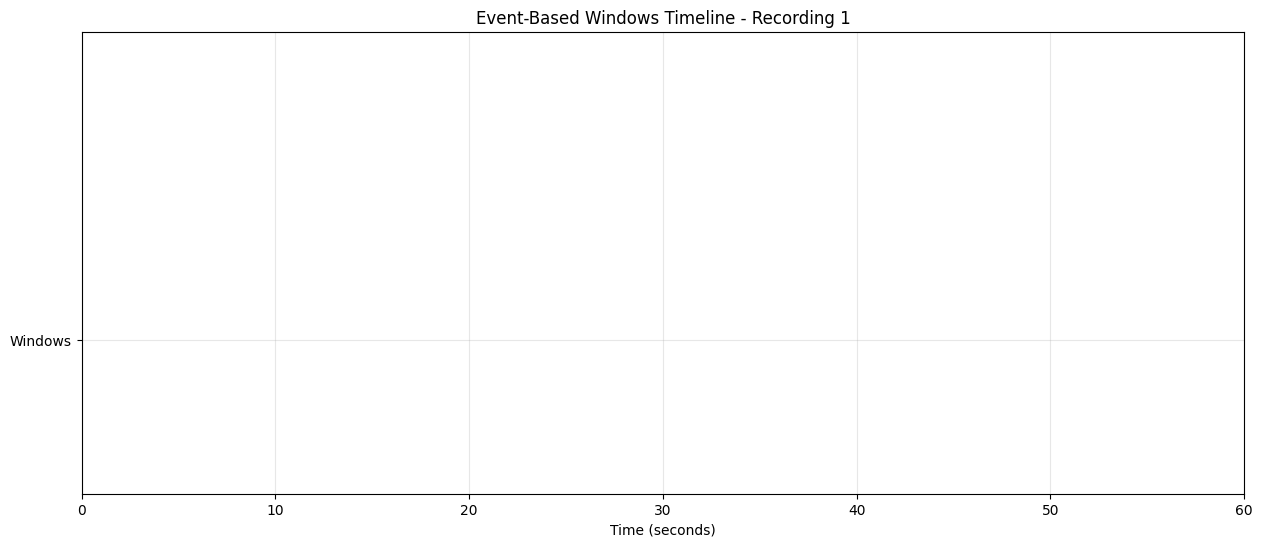

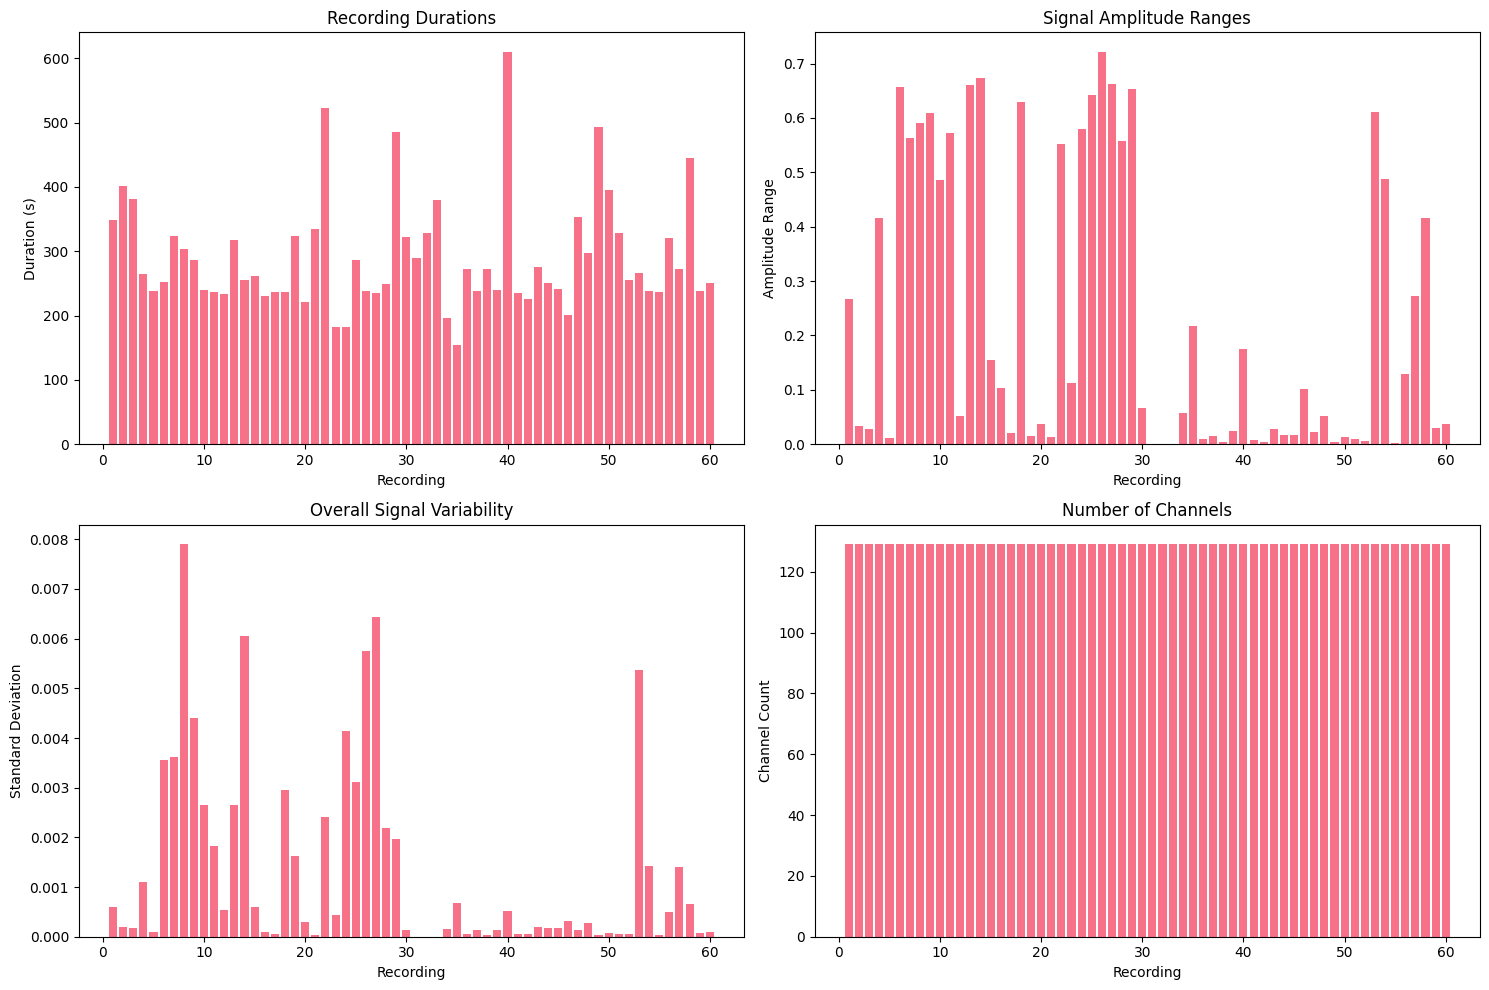

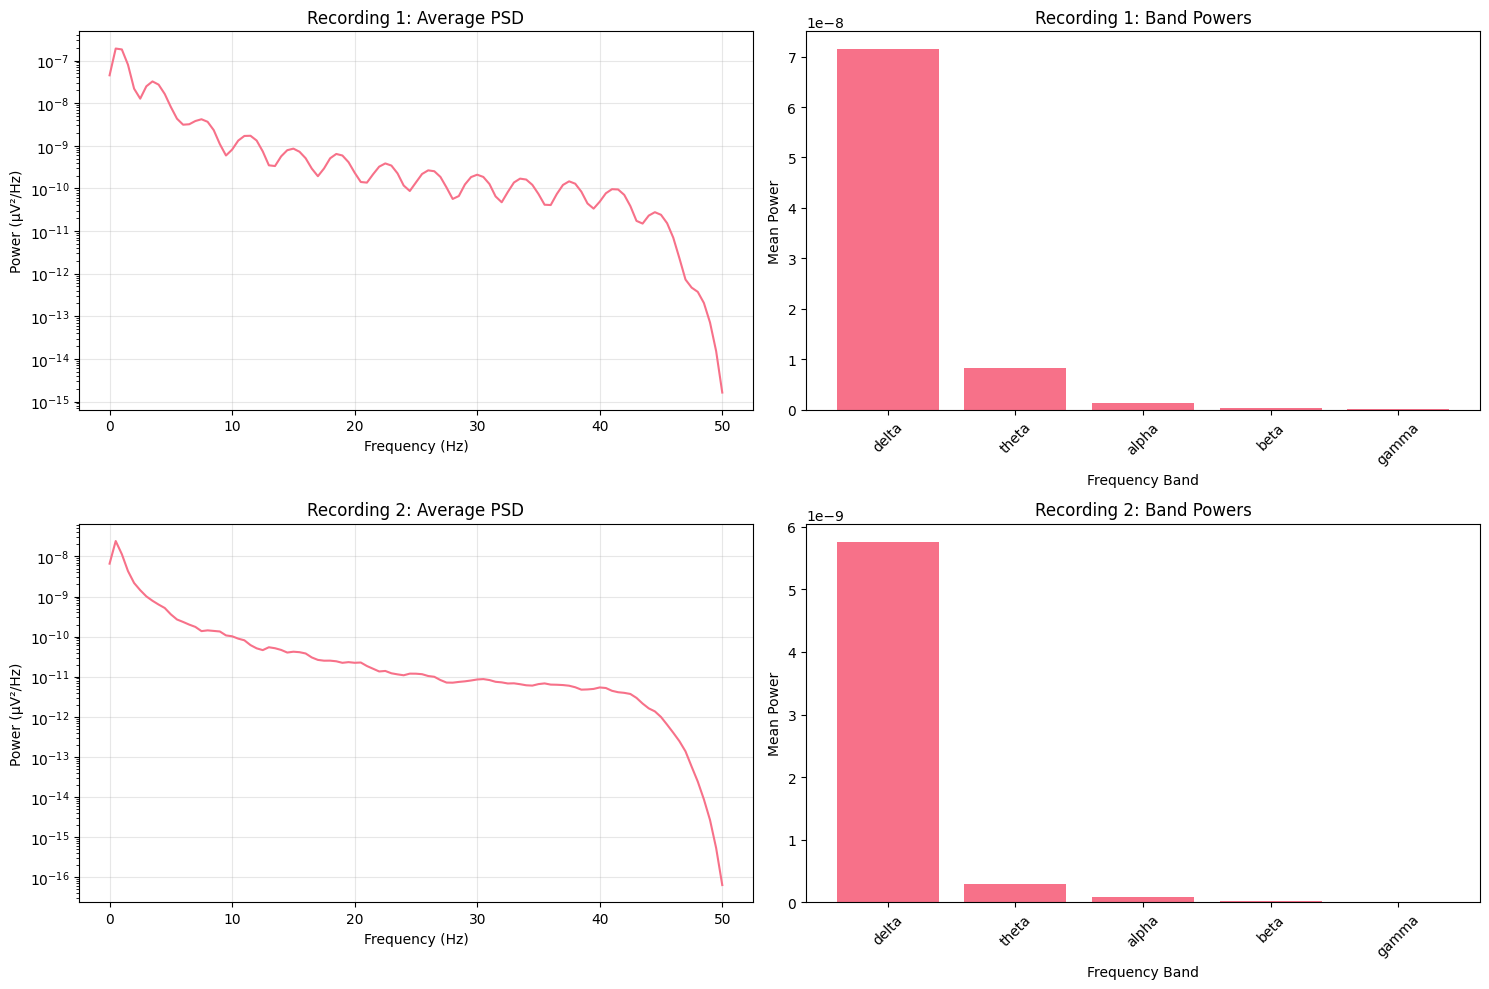


HYBRID EDA COMPLETE!

SUMMARY:
  Recordings analyzed: 60
  Preprocessing: Partial
  Signal quality: 60 recordings
  Frequency analysis: 2 recordings
  Windows created: 2941
  Baseline model: EEGNeX ready

NEXT STEPS:
  1. Experiment with different preprocessing parameters
  2. Implement custom EEG-GPT architecture
  3. Compare performance against EEGNeX baseline
  4. Scale to full dataset (mini=False)

Analysis complete! Results stored in 'results' dictionary.
\nEDA Results Saved:
  📊 Recordings DataFrame: ./analysis/summaries/recordings_comprehensive_20250905_191842.csv
  📋 Summary: ./analysis/summaries/eda_summary_20250905_191842.json
  🐍 Python DataFrame: ./analysis/summaries/recordings_df_20250905_191842.pkl

Key Insights:
  Total recordings: 60
  Training windows: 2,941
  Filter type: Custom Gentle Suppression
  Zero signal recordings: 3
  Training ready: True

USAGE EXAMPLES:
# Access saved data
recordings_df, summary, files_saved = save_eda_results(results)

# Access loaded dat

In [13]:
if __name__ == "__main__":
    # Run the comprehensive hybrid EDA
    print("Starting Hybrid EEG Foundation Model EDA")

    # Default: Custom gentle filtering approach (recommended)
    results = run_hybrid_eda(
        task="contrastChangeDetection",
        release="R5",
        mini=True,
        use_custom_filter=True,  # Use our custom approach
        custom_filter_params={
            'target_freqs': [60, 120, 180],  # Target line noise harmonics
            'suppression_db': 6,             # Gentle 6dB suppression
            'method': 'gentle_fft'           # FFT-based method
        }
    )

    # Alternative: Standard approach (uncomment to use instead)
    # results = run_hybrid_eda(
    #     task="contrastChangeDetection",
    #     release="R5",
    #     mini=True,
    #     use_custom_filter=False  # Standard notch filter
    # )

    if results:
        print("\nAnalysis complete! Results stored in 'results' dictionary.")

        # Automatically save comprehensive DataFrame and summary
        recordings_df, summary, files_saved = save_eda_results(results)

        print("\nKey Insights:")
        print(f"  Total recordings: {summary['dataset_overview']['total_recordings']}")
        print(f"  Training windows: {summary['dataset_overview']['total_windows']:,}")
        print(f"  Filter type: {summary['dataset_overview']['filter_type']}")
        print(f"  Zero signal recordings: {summary['data_quality']['zero_signal_recordings']}")
        print(f"  Training ready: {summary['model_readiness']['training_ready']}")

        print("\nUSAGE EXAMPLES:")
        print("# Access saved data")
        print("recordings_df, summary, files_saved = save_eda_results(results)")
        print()
        print("# Access loaded dataset")
        print("dataset = results['dataset']")
        print()
        print("# Access PyTorch dataloader")
        print("dataloader = results['dataloader']")
        print()
        print("# Access baseline model")
        print("model = results['baseline_model']")
        print()
        print("# Start training loop")
        print("for batch_X, batch_y in dataloader:")
        print("    predictions = model(batch_X)")
        print("    # ... training code ...")

    else:
        print("Analysis failed. Check internet connection and try again.")


In [14]:
def create_grayscale_visualization(results, n_examples=3, recording_idx=0):
    """
    Create grayscale 2D image representations of EEG windows for visual inspection

    Parameters:
    - results: EDA results dictionary
    - n_examples: Number of example windows to show
    - recording_idx: Which recording to visualize (0-based index)
    """
    print(f"\nCreating Grayscale EEG Visualizations")
    print("=" * 50)

    if not results.get('windowed_data'):
        print("No windowed data available. Run windowing first.")
        return None

    windowed_data = results['windowed_data']
    if recording_idx >= len(windowed_data):
        print(f"Recording index {recording_idx} not available. Max index: {len(windowed_data)-1}")
        return None

    # Get dynamic sampling rate information
    target_sfreq = results.get('target_sfreq', 100)
    original_sfreq = results.get('original_sfreq', 500)

    recording_windows = windowed_data[recording_idx]
    n_examples = min(n_examples, len(recording_windows))

    # Calculate dynamic parameters
    window_samples = recording_windows[0].shape[1]
    duration_s = window_samples / target_sfreq
    n_channels = recording_windows[0].shape[0]

    fig, axes = plt.subplots(2, n_examples, figsize=(4*n_examples, 8))
    if n_examples == 1:
        axes = axes.reshape(-1, 1)

    print(f"Showing {n_examples} example windows from recording {recording_idx+1}")
    print(f"Window shape: {recording_windows[0].shape} (channels, time_samples)")
    print(f"Sampling rate: {target_sfreq} Hz (Original: {original_sfreq} Hz)")
    print(f"Window duration: {duration_s:.1f}s")

    for i in range(n_examples):
        window_data = recording_windows[i]  # Shape: (n_channels, n_samples)

        # Raw amplitude visualization
        im1 = axes[0, i].imshow(window_data, aspect='auto', cmap='RdBu_r',
                               interpolation='nearest')
        axes[0, i].set_title(f'Raw Amplitudes\\nWindow {i+1}')
        axes[0, i].set_xlabel(f'Time Samples ({duration_s:.1f}s @ {target_sfreq}Hz)')
        axes[0, i].set_ylabel(f'EEG Channels ({n_channels})')
        plt.colorbar(im1, ax=axes[0, i], label='Amplitude (µV)')

        # Normalized grayscale (0-255) for model input
        normalized = ((window_data - window_data.min()) /
                     (window_data.max() - window_data.min()) * 255).astype(np.uint8)

        im2 = axes[1, i].imshow(normalized, aspect='auto', cmap='gray',
                               interpolation='nearest')
        axes[1, i].set_title(f'Grayscale (0-255)\\nWindow {i+1}')
        axes[1, i].set_xlabel(f'Time Samples ({duration_s:.1f}s @ {target_sfreq}Hz)')
        axes[1, i].set_ylabel(f'EEG Channels ({n_channels})')
        plt.colorbar(im2, ax=axes[1, i], label='Grayscale Value')

        # Print statistics
        print(f"  Window {i+1}:")
        print(f"    Raw range: {window_data.min():.4f} to {window_data.max():.4f}")
        print(f"    Raw std: {window_data.std():.4f}")
        print(f"    Grayscale range: {normalized.min()} to {normalized.max()}")

    plt.tight_layout()
    plt.show()

    return normalized  # Return last normalized window for further analysis

def create_psd_spectrogram_visualization(results, channel_names=['E1', 'E5', 'E10'],
                                       recording_idx=0, window_idx=0):
    """
    Create PSD spectrograms for selected channels to inspect frequency content

    Parameters:
    - results: EDA results dictionary
    - channel_names: List of channel names to visualize
    - recording_idx: Which recording to use
    - window_idx: Which window to analyze
    """
    print(f"\nCreating PSD Spectrogram Visualizations")
    print("=" * 50)

    if not results.get('windowed_data'):
        print("No windowed data available. Run windowing first.")
        return None

    # Get data and dynamic sampling rate
    windowed_data = results['windowed_data']
    dataset = results['dataset']
    target_sfreq = results.get('target_sfreq', 100)
    original_sfreq = results.get('original_sfreq', 500)

    if recording_idx >= len(windowed_data):
        print(f"Recording index {recording_idx} not available.")
        return None

    recording_windows = windowed_data[recording_idx]
    if window_idx >= len(recording_windows):
        print(f"Window index {window_idx} not available.")
        return None

    window_data = recording_windows[window_idx]  # Shape: (n_channels, n_samples)
    raw = dataset.datasets[recording_idx].raw
    all_channel_names = raw.ch_names
    fs = target_sfreq  # Use the target sampling frequency
    nyquist_freq = fs / 2

    # Find channel indices
    channel_indices = []
    available_channels = []
    for ch_name in channel_names:
        if ch_name in all_channel_names:
            channel_indices.append(all_channel_names.index(ch_name))
            available_channels.append(ch_name)
        else:
            print(f"Channel {ch_name} not found. Available: {all_channel_names[:10]}...")

    if not channel_indices:
        print("No valid channels found. Using first 3 channels.")
        channel_indices = [0, 1, 2]
        available_channels = all_channel_names[:3]

    n_channels = len(channel_indices)
    fig, axes = plt.subplots(2, n_channels, figsize=(5*n_channels, 8))
    if n_channels == 1:
        axes = axes.reshape(-1, 1)

    print(f"Analyzing channels: {available_channels}")
    print(f"Window {window_idx+1} from recording {recording_idx+1}")
    print(f"Sampling rate: {fs} Hz (Original: {original_sfreq} Hz)")
    print(f"Window duration: {window_data.shape[1]/fs:.1f}s")
    print(f"Nyquist frequency: {nyquist_freq} Hz")

    # Explain Nyquist limitation
    if nyquist_freq < 60:
        print(f"⚠️  Limited frequency analysis: max detectable frequency is {nyquist_freq} Hz")
        print("   60Hz line noise detection requires sampling >120Hz")
    else:
        print(f"✅ Full frequency analysis available up to {nyquist_freq} Hz")

    for i, (ch_idx, ch_name) in enumerate(zip(channel_indices, available_channels)):
        channel_data = window_data[ch_idx, :]  # Shape: (n_samples,)

        # Time domain plot
        time_axis = np.arange(len(channel_data)) / fs
        axes[0, i].plot(time_axis, channel_data, 'b-', linewidth=0.8)
        axes[0, i].set_title(f'Channel {ch_name}\\nTime Domain')
        axes[0, i].set_xlabel('Time (s)')
        axes[0, i].set_ylabel('Amplitude (µV)')
        axes[0, i].grid(True, alpha=0.3)

        # Compute and plot PSD
        freqs, psd = signal.welch(channel_data, fs=fs, nperseg=min(128, len(channel_data)//2))

        axes[1, i].semilogy(freqs, psd, 'r-', linewidth=1.5)
        axes[1, i].set_title(f'Channel {ch_name}\\nPSD (0-{nyquist_freq}Hz)')
        axes[1, i].set_xlabel('Frequency (Hz)')
        axes[1, i].set_ylabel('Power (µV²/Hz)')
        axes[1, i].grid(True, alpha=0.3)

        # Dynamic frequency band highlighting based on Nyquist limit
        if nyquist_freq >= 13:  # Alpha band
            axes[1, i].axvspan(8, min(13, nyquist_freq), alpha=0.2, color='green', label='Alpha (8-13Hz)')
        if nyquist_freq >= 30:  # Beta band
            axes[1, i].axvspan(13, min(30, nyquist_freq), alpha=0.2, color='blue', label='Beta (13-30Hz)')

        # Line noise detection - only if detectable
        if nyquist_freq >= 60:
            axes[1, i].axvline(60, color='red', linestyle='--', alpha=0.7, label='60Hz Line Noise')
            if nyquist_freq >= 120:
                axes[1, i].axvline(120, color='red', linestyle='--', alpha=0.5, label='120Hz Harmonic')
            # Add analysis note
            axes[1, i].text(0.02, 0.98, f'60Hz analysis enabled\\n(sampling: {fs}Hz)',
                           transform=axes[1, i].transAxes, fontsize=8, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        else:
            # Add warning about limited analysis
            axes[1, i].text(0.02, 0.98, f'60Hz line noise\\nrequires >120Hz sampling\\n(current: {fs}Hz)',
                           transform=axes[1, i].transAxes, fontsize=8, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))

        axes[1, i].legend(fontsize=8)

        # Print channel statistics
        dominant_freq = freqs[np.argmax(psd)]
        total_power = np.trapz(psd, freqs)
        print(f"  Channel {ch_name}:")
        print(f"    Peak frequency: {dominant_freq:.1f} Hz")
        print(f"    Total power: {total_power:.2e}")
        print(f"    RMS amplitude: {np.sqrt(np.mean(channel_data**2)):.4f}")

    plt.tight_layout()
    plt.show()

    return freqs, psd  # Return last channel's frequency analysis

def create_filtering_comparison(results, channel_name='E1', recording_idx=0, window_idx=0):
    """
    Compare original vs filtered data to verify custom filtering effectiveness

    This function shows the effect of custom gentle filtering on line noise
    """
    print(f"\nFiltering Effectiveness Check")
    print("=" * 50)

    if not results.get('windowed_data'):
        print("No windowed data available.")
        return None

    # Get filtered data and dynamic sampling rate
    windowed_data = results['windowed_data']
    dataset = results['dataset']
    target_sfreq = results.get('target_sfreq', 100)
    original_sfreq = results.get('original_sfreq', 500)

    window_data = windowed_data[recording_idx][window_idx]
    raw = dataset.datasets[recording_idx].raw
    all_channel_names = raw.ch_names
    fs = target_sfreq  # Use the target sampling frequency
    nyquist_freq = fs / 2

    # Find channel
    if channel_name not in all_channel_names:
        channel_name = all_channel_names[0]
        print(f"Channel not found, using {channel_name}")

    ch_idx = all_channel_names.index(channel_name)
    filtered_data = window_data[ch_idx, :]

    print(f"Sampling rate used: {fs} Hz")
    print(f"Nyquist frequency: {nyquist_freq} Hz")

    # For comparison, we'd need original data, but since we've already processed it,
    # we'll focus on showing the filtering results
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Time domain
    time_axis = np.arange(len(filtered_data)) / fs
    axes[0, 0].plot(time_axis, filtered_data, 'b-', linewidth=0.8)
    axes[0, 0].set_title(f'Filtered Signal - Channel {channel_name} ({fs}Hz)')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude (µV)')
    axes[0, 0].grid(True, alpha=0.3)

    # PSD with line noise indicators
    freqs, psd = signal.welch(filtered_data, fs=fs, nperseg=min(128, len(filtered_data)//2))
    axes[0, 1].semilogy(freqs, psd, 'b-', linewidth=1.5)
    axes[0, 1].set_title(f'PSD After Filtering - Channel {channel_name} ({fs}Hz)')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Power (µV²/Hz)')
    axes[0, 1].grid(True, alpha=0.3)

    # Highlight target frequencies for custom filtering - only if within Nyquist
    target_freqs = results.get('custom_filter_params', {}).get('target_freqs', [60, 120, 180])
    for freq in target_freqs:
        if freq < nyquist_freq:
            axes[0, 1].axvline(freq, color='red', linestyle='--', alpha=0.7,
                              label=f'{freq}Hz Target')
    axes[0, 1].legend()

    # Spectrogram
    f, t, Sxx = signal.spectrogram(filtered_data, fs, nperseg=min(64, len(filtered_data)//4))
    im = axes[1, 0].pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud', cmap='viridis')
    axes[1, 0].set_title(f'Spectrogram - Channel {channel_name} ({fs}Hz)')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im, ax=axes[1, 0], label='Power (dB)')

    # Line noise analysis around 60Hz - only if 60Hz is within Nyquist
    if nyquist_freq >= 60:
        freq_60_idx = np.argmin(np.abs(freqs - 60))
        freq_window = slice(max(0, freq_60_idx-5), min(len(freqs), freq_60_idx+6))

        axes[1, 1].plot(freqs[freq_window], psd[freq_window], 'ro-', markersize=4)
        axes[1, 1].set_title('60Hz Region Detail')
        axes[1, 1].set_xlabel('Frequency (Hz)')
        axes[1, 1].set_ylabel('Power (µV²/Hz)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axvline(60, color='red', linestyle='--', alpha=0.7)
    else:
        axes[1, 1].text(0.5, 0.5, f'60Hz analysis not possible\\nNyquist limit: {nyquist_freq}Hz\\nNeed >120Hz sampling',
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))

    plt.tight_layout()
    plt.show()

    # Print filtering assessment
    filter_type = results.get('filter_type', 'Unknown')
    print(f"Filter type used: {filter_type}")

    if 'Custom' in filter_type:
        suppression_db = results.get('custom_filter_params', {}).get('suppression_db', 'Unknown')
        print(f"Target suppression: {suppression_db} dB")

    # Check for residual line noise
    if len(freqs) > freq_60_idx:
        power_60hz = psd[freq_60_idx]
        nearby_power = np.mean(psd[max(0, freq_60_idx-3):freq_60_idx]) + np.mean(psd[freq_60_idx+1:min(len(psd), freq_60_idx+4)])
        nearby_power /= 2

        if power_60hz > 3 * nearby_power:
            print(f"⚠️  Warning: Significant 60Hz peak still present (ratio: {power_60hz/nearby_power:.1f})")
        else:
            print(f"✅ 60Hz suppression appears effective (ratio: {power_60hz/nearby_power:.1f})")

def spot_check_preprocessing(results, recording_idx=0):
    """
    Comprehensive spot-check of preprocessing results

    Parameters:
    - results: EDA results dictionary
    - recording_idx: Which recording to analyze (default: 0)
    """
    print("\n" + "="*70)
    print("PREPROCESSING SPOT-CHECK VISUALIZATION")
    print("="*70)

    if not results:
        print("No results available for spot-checking.")
        return

    # 1. Grayscale visualization
    print("\n1. GRAYSCALE EEG REPRESENTATION CHECK")
    normalized_window = create_grayscale_visualization(results, n_examples=3,
                                                      recording_idx=recording_idx)

    # 2. PSD analysis
    print("\n2. FREQUENCY DOMAIN ANALYSIS CHECK")
    freqs, psd = create_psd_spectrogram_visualization(results,
                                                     channel_names=['E1', 'E5', 'E10'],  # Use actual channel names
                                                     recording_idx=recording_idx,
                                                     window_idx=0)

    # 3. Filtering effectiveness
    print("\n3. FILTERING EFFECTIVENESS CHECK")
    create_filtering_comparison(results, channel_name='E1',  # Use actual channel name
                               recording_idx=recording_idx, window_idx=0)

    # 4. 30-second longer-term visualizations
    print("\n4. LONGER-TERM ANALYSIS (30-SECOND VIEWS)")
    print("=" * 50)

    # 30-second grayscale visualization
    print("\n4a. 30-Second Grayscale Visualization")
    normalized_30sec = create_30sec_grayscale_visualization(results, recording_idx=recording_idx)

    # 30-second single-channel PSD analysis
    print("\n4b. 30-Second Single Channel PSD Analysis")
    freqs_30sec, psd_30sec = create_30sec_single_channel_psd(results, channel_name='E1',
                                                            recording_idx=recording_idx)

    print("\n" + "="*70)
    print("COMPREHENSIVE SPOT-CHECK COMPLETE")
    print("="*70)
    print("✅ Review the visualizations above to verify:")
    print("  1. Grayscale images show clear EEG patterns (2s windows)")
    print("  2. PSD shows expected frequency content (multiple channels)")
    print("  3. Line noise (60Hz, 120Hz) is appropriately suppressed")
    print("  4. Neural frequency bands (alpha, beta) are preserved")
    print("  5. 30-second grayscale shows longer-term EEG structure")
    print("  6. 30-second single-channel analysis reveals temporal stability")

    return {
        'normalized_2sec': normalized_window,
        'freqs_2sec': freqs,
        'psd_2sec': psd,
        'normalized_30sec': normalized_30sec,
        'freqs_30sec': freqs_30sec,
        'psd_30sec': psd_30sec
    }

def create_30sec_grayscale_visualization(results, recording_idx=0):
    """
    Create a 30-second grayscale visualization for longer-term EEG pattern analysis

    Parameters:
    - results: EDA results dictionary
    - recording_idx: Which recording to visualize (0-based index)
    """
    print(f"\n30-SECOND GRAYSCALE EEG VISUALIZATION")
    print("=" * 50)

    if not results.get('dataset'):
        print("No dataset available for 30-second visualization.")
        return None

    # Get dynamic sampling rate information
    target_sfreq = results.get('target_sfreq', 100)
    original_sfreq = results.get('original_sfreq', 500)
    dataset = results['dataset']

    if recording_idx >= len(dataset.datasets):
        print(f"Recording index {recording_idx} not available.")
        return None

    # Get 30 seconds of data
    raw = dataset.datasets[recording_idx].raw
    duration_samples = int(30 * target_sfreq)  # 30 seconds worth of samples
    start_sample = 0
    end_sample = min(duration_samples, raw.n_times)

    # Extract data
    eeg_data = raw.get_data()[:, start_sample:end_sample]  # Shape: (n_channels, n_samples)
    actual_duration = eeg_data.shape[1] / target_sfreq

    print(f"30-second view from recording {recording_idx+1}")
    print(f"Data shape: {eeg_data.shape} (channels, time_samples)")
    print(f"Sampling rate: {target_sfreq} Hz (Original: {original_sfreq} Hz)")
    print(f"Actual duration: {actual_duration:.1f}s")

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))

    # Raw amplitude visualization
    im1 = axes[0].imshow(eeg_data, aspect='auto', cmap='RdBu_r', interpolation='nearest')
    axes[0].set_title(f'30-Second Raw EEG Amplitudes - Recording {recording_idx+1}\\n({target_sfreq}Hz sampling)')
    axes[0].set_xlabel(f'Time Samples ({actual_duration:.1f}s @ {target_sfreq}Hz)')
    axes[0].set_ylabel(f'EEG Channels ({eeg_data.shape[0]})')
    plt.colorbar(im1, ax=axes[0], label='Amplitude (µV)')

    # Add time markers every 5 seconds
    for t in range(5, int(actual_duration), 5):
        sample_pos = t * target_sfreq
        axes[0].axvline(sample_pos, color='white', linestyle='--', alpha=0.5, linewidth=0.8)
        axes[0].text(sample_pos, eeg_data.shape[0]*0.95, f'{t}s', color='white', fontsize=8, ha='center')

    # Normalized grayscale (0-255) for model input
    normalized = ((eeg_data - eeg_data.min()) / (eeg_data.max() - eeg_data.min()) * 255).astype(np.uint8)

    im2 = axes[1].imshow(normalized, aspect='auto', cmap='gray', interpolation='nearest')
    axes[1].set_title(f'30-Second Normalized Grayscale (0-255) - Recording {recording_idx+1}\\n({target_sfreq}Hz sampling)')
    axes[1].set_xlabel(f'Time Samples ({actual_duration:.1f}s @ {target_sfreq}Hz)')
    axes[1].set_ylabel(f'EEG Channels ({eeg_data.shape[0]})')
    plt.colorbar(im2, ax=axes[1], label='Grayscale Value')

    # Add time markers every 5 seconds
    for t in range(5, int(actual_duration), 5):
        sample_pos = t * target_sfreq
        axes[1].axvline(sample_pos, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        axes[1].text(sample_pos, eeg_data.shape[0]*0.95, f'{t}s', color='red', fontsize=8, ha='center')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"30-second data statistics:")
    print(f"  Raw range: {eeg_data.min():.4f} to {eeg_data.max():.4f}")
    print(f"  Raw std: {eeg_data.std():.4f}")
    print(f"  Grayscale range: {normalized.min()} to {normalized.max()}")

    return normalized

def create_30sec_single_channel_psd(results, channel_name='E1', recording_idx=0):
    """
    Create a 30-second single-channel PSD analysis for longer-term frequency content

    Parameters:
    - results: EDA results dictionary
    - channel_name: Channel name to visualize
    - recording_idx: Which recording to use
    """
    print(f"\n30-SECOND SINGLE CHANNEL PSD ANALYSIS")
    print("=" * 50)

    if not results.get('dataset'):
        print("No dataset available for 30-second PSD analysis.")
        return None

    # Get data and dynamic sampling rate
    dataset = results['dataset']
    target_sfreq = results.get('target_sfreq', 100)
    original_sfreq = results.get('original_sfreq', 500)
    nyquist_freq = target_sfreq / 2

    if recording_idx >= len(dataset.datasets):
        print(f"Recording index {recording_idx} not available.")
        return None

    raw = dataset.datasets[recording_idx].raw
    all_channel_names = raw.ch_names

    # Find channel
    if channel_name not in all_channel_names:
        channel_name = all_channel_names[0]
        print(f"Channel not found, using {channel_name}")

    ch_idx = all_channel_names.index(channel_name)

    # Get 30 seconds of data
    duration_samples = int(30 * target_sfreq)  # 30 seconds worth of samples
    start_sample = 0
    end_sample = min(duration_samples, raw.n_times)

    channel_data = raw.get_data()[ch_idx, start_sample:end_sample]
    actual_duration = len(channel_data) / target_sfreq

    print(f"Analyzing channel: {channel_name}")
    print(f"30-second view from recording {recording_idx+1}")
    print(f"Sampling rate: {target_sfreq} Hz (Original: {original_sfreq} Hz)")
    print(f"Actual duration: {actual_duration:.1f}s")
    print(f"Nyquist frequency: {nyquist_freq} Hz")

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. Time domain plot
    time_axis = np.arange(len(channel_data)) / target_sfreq
    axes[0, 0].plot(time_axis, channel_data, 'b-', linewidth=0.5)
    axes[0, 0].set_title(f'30-Second Time Domain - Channel {channel_name}\\n({target_sfreq}Hz sampling)')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude (µV)')
    axes[0, 0].grid(True, alpha=0.3)

    # Add time markers every 5 seconds
    for t in range(5, int(actual_duration), 5):
        axes[0, 0].axvline(t, color='gray', linestyle='--', alpha=0.5)
        axes[0, 0].text(t, axes[0, 0].get_ylim()[1]*0.9, f'{t}s', fontsize=8, ha='center')

    # 2. PSD using Welch's method
    freqs, psd = signal.welch(channel_data, fs=target_sfreq, nperseg=min(512, len(channel_data)//4))

    axes[0, 1].semilogy(freqs, psd, 'r-', linewidth=1.5)
    axes[0, 1].set_title(f'30-Second PSD - Channel {channel_name}\\n(0-{nyquist_freq}Hz)')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Power (µV²/Hz)')
    axes[0, 1].grid(True, alpha=0.3)

    # Dynamic frequency band highlighting
    if nyquist_freq >= 13:  # Alpha band
        axes[0, 1].axvspan(8, min(13, nyquist_freq), alpha=0.2, color='green', label='Alpha (8-13Hz)')
    if nyquist_freq >= 30:  # Beta band
        axes[0, 1].axvspan(13, min(30, nyquist_freq), alpha=0.2, color='blue', label='Beta (13-30Hz)')

    # Line noise detection
    if nyquist_freq >= 60:
        axes[0, 1].axvline(60, color='red', linestyle='--', alpha=0.7, label='60Hz Line Noise')
        if nyquist_freq >= 120:
            axes[0, 1].axvline(120, color='red', linestyle='--', alpha=0.5, label='120Hz Harmonic')
    axes[0, 1].legend(fontsize=8)

    # 3. Spectrogram
    f_spec, t_spec, Sxx = signal.spectrogram(channel_data, fs=target_sfreq, nperseg=256)
    im = axes[1, 0].pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
    axes[1, 0].set_title(f'30-Second Spectrogram - Channel {channel_name}\\n({target_sfreq}Hz sampling)')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    plt.colorbar(im, ax=axes[1, 0], label='Power (dB)')

    # 4. Statistical summary over time (5-second windows)
    window_size = int(5 * target_sfreq)  # 5-second windows
    n_windows = len(channel_data) // window_size

    if n_windows > 1:
        window_stats = []
        window_times = []

        for i in range(n_windows):
            start_idx = i * window_size
            end_idx = (i + 1) * window_size
            window_segment = channel_data[start_idx:end_idx]

            window_stats.append({
                'mean': np.mean(window_segment),
                'std': np.std(window_segment),
                'rms': np.sqrt(np.mean(window_segment**2))
            })
            window_times.append((i + 0.5) * 5)  # Middle of each 5-second window

        # Plot RMS over time
        rms_values = [ws['rms'] for ws in window_stats]
        axes[1, 1].plot(window_times, rms_values, 'go-', linewidth=2, markersize=6)
        axes[1, 1].set_title(f'Signal Quality Over Time - Channel {channel_name}\\n(5-second RMS windows)')
        axes[1, 1].set_xlabel('Time (s)')
        axes[1, 1].set_ylabel('RMS Amplitude (µV)')
        axes[1, 1].grid(True, alpha=0.3)

        # Add quality assessment
        mean_rms = np.mean(rms_values)
        std_rms = np.std(rms_values)
        if std_rms / mean_rms < 0.3:
            quality_text = "✅ Stable signal quality"
        else:
            quality_text = "⚠️ Variable signal quality"

        axes[1, 1].text(0.02, 0.98, quality_text, transform=axes[1, 1].transAxes,
                       fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data\\nfor temporal analysis',
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))

    plt.tight_layout()
    plt.show()

    # Print comprehensive statistics
    dominant_freq = freqs[np.argmax(psd)]
    total_power = np.trapz(psd, freqs)

    print(f"30-second analysis results:")
    print(f"  Peak frequency: {dominant_freq:.1f} Hz")
    print(f"  Total power: {total_power:.2e}")
    print(f"  RMS amplitude: {np.sqrt(np.mean(channel_data**2)):.4f}")
    print(f"  Signal variance: {np.var(channel_data):.6f}")

    # Frequency band power analysis
    if nyquist_freq >= 13:
        alpha_mask = (freqs >= 8) & (freqs <= 13)
        alpha_power = np.trapz(psd[alpha_mask], freqs[alpha_mask])
        print(f"  Alpha band power (8-13Hz): {alpha_power:.2e}")

    if nyquist_freq >= 30:
        beta_mask = (freqs >= 13) & (freqs <= 30)
        beta_power = np.trapz(psd[beta_mask], freqs[beta_mask])
        print(f"  Beta band power (13-30Hz): {beta_power:.2e}")

    return freqs, psd


PREPROCESSING SPOT-CHECK VISUALIZATION

1. GRAYSCALE EEG REPRESENTATION CHECK

Creating Grayscale EEG Visualizations
Showing 3 example windows from recording 1
Window shape: (129, 250) (channels, time_samples)
Sampling rate: 125 Hz (Original: 100.0 Hz)
Window duration: 2.0s
  Window 1:
    Raw range: -0.0042 to 0.0052
    Raw std: 0.0002
    Grayscale range: 0 to 255
  Window 2:
    Raw range: -0.0001 to 0.0001
    Raw std: 0.0000
    Grayscale range: 0 to 255
  Window 3:
    Raw range: -0.0001 to 0.0003
    Raw std: 0.0000
    Grayscale range: 0 to 255


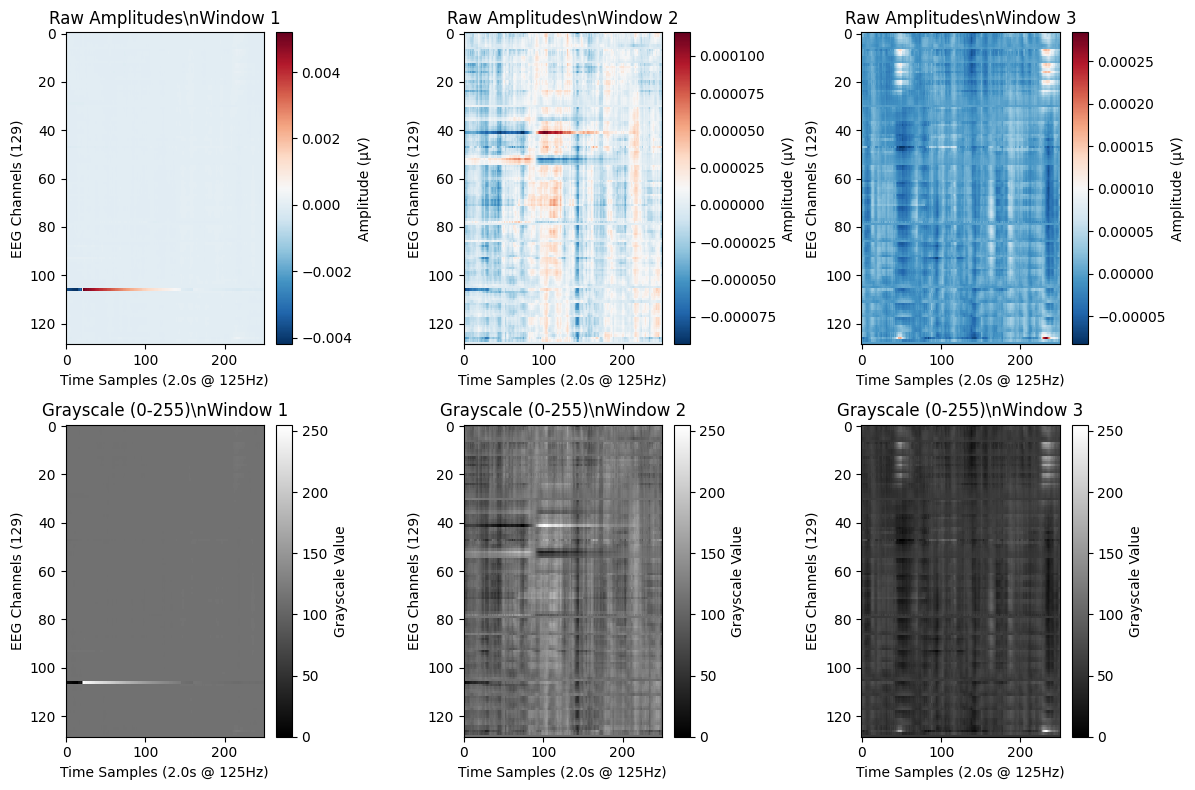


2. FREQUENCY DOMAIN ANALYSIS CHECK

Creating PSD Spectrogram Visualizations
Analyzing channels: ['E1', 'E5', 'E10']
Window 1 from recording 1
Sampling rate: 125 Hz (Original: 100.0 Hz)
Window duration: 2.0s
Nyquist frequency: 62.5 Hz
✅ Full frequency analysis available up to 62.5 Hz
  Channel E1:
    Peak frequency: 1.0 Hz
    Total power: 1.51e-10
    RMS amplitude: 0.0000
  Channel E5:
    Peak frequency: 1.0 Hz
    Total power: 7.24e-11
    RMS amplitude: 0.0000
  Channel E10:
    Peak frequency: 1.0 Hz
    Total power: 2.20e-10
    RMS amplitude: 0.0000


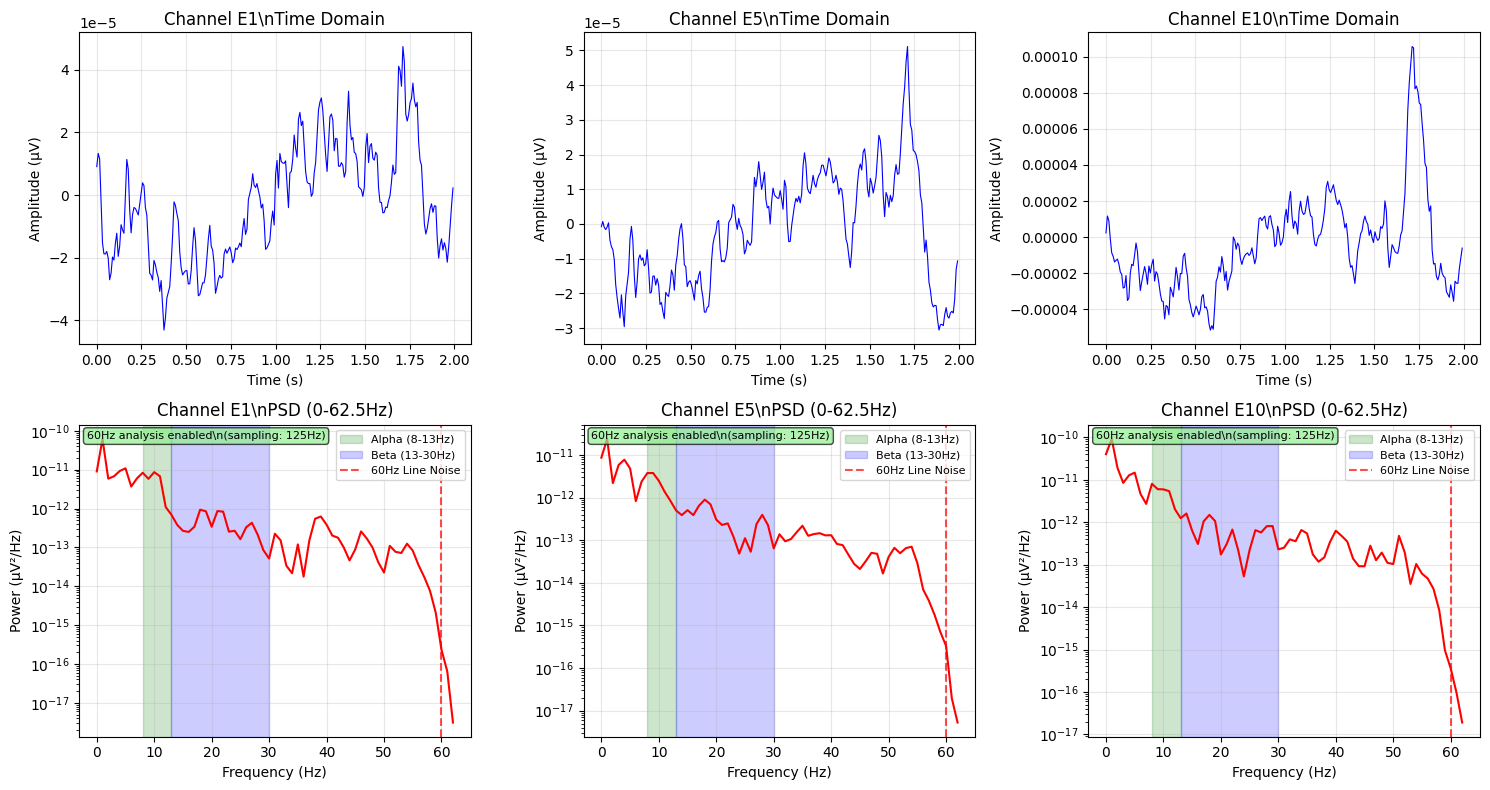


3. FILTERING EFFECTIVENESS CHECK

Filtering Effectiveness Check
Sampling rate used: 125 Hz
Nyquist frequency: 62.5 Hz


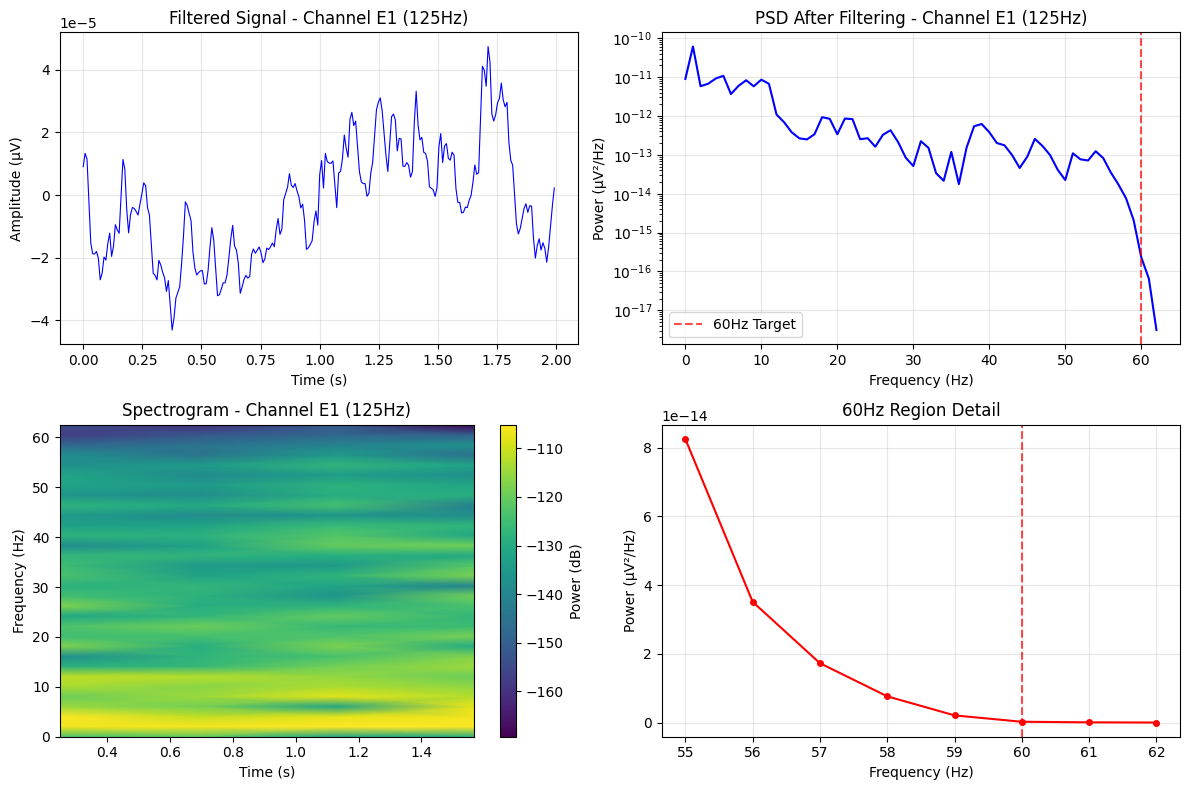

Filter type used: Custom Gentle Suppression
Target suppression: Unknown dB
✅ 60Hz suppression appears effective (ratio: 0.1)

4. LONGER-TERM ANALYSIS (30-SECOND VIEWS)

4a. 30-Second Grayscale Visualization

30-SECOND GRAYSCALE EEG VISUALIZATION
30-second view from recording 1
Data shape: (129, 3750) (channels, time_samples)
Sampling rate: 125 Hz (Original: 100.0 Hz)
Actual duration: 30.0s


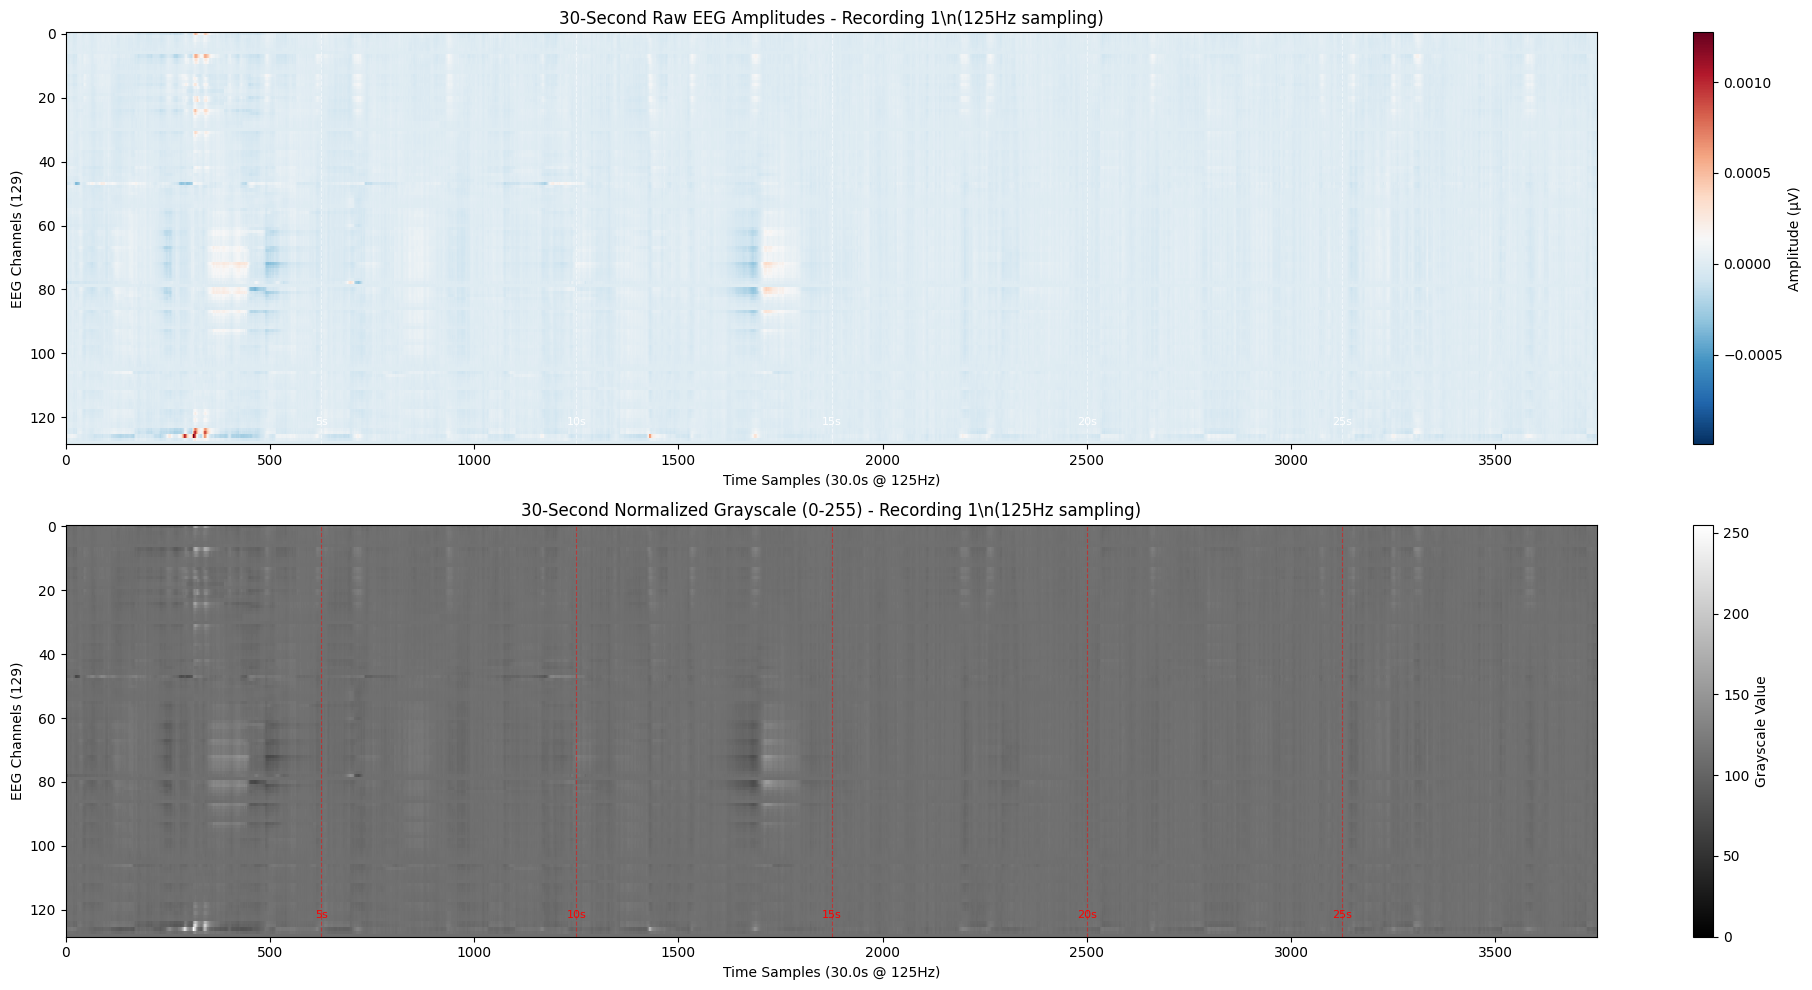

30-second data statistics:
  Raw range: -0.0010 to 0.0013
  Raw std: 0.0000
  Grayscale range: 0 to 255

4b. 30-Second Single Channel PSD Analysis

30-SECOND SINGLE CHANNEL PSD ANALYSIS
Analyzing channel: E1
30-second view from recording 1
Sampling rate: 125 Hz (Original: 100.0 Hz)
Actual duration: 30.0s
Nyquist frequency: 62.5 Hz


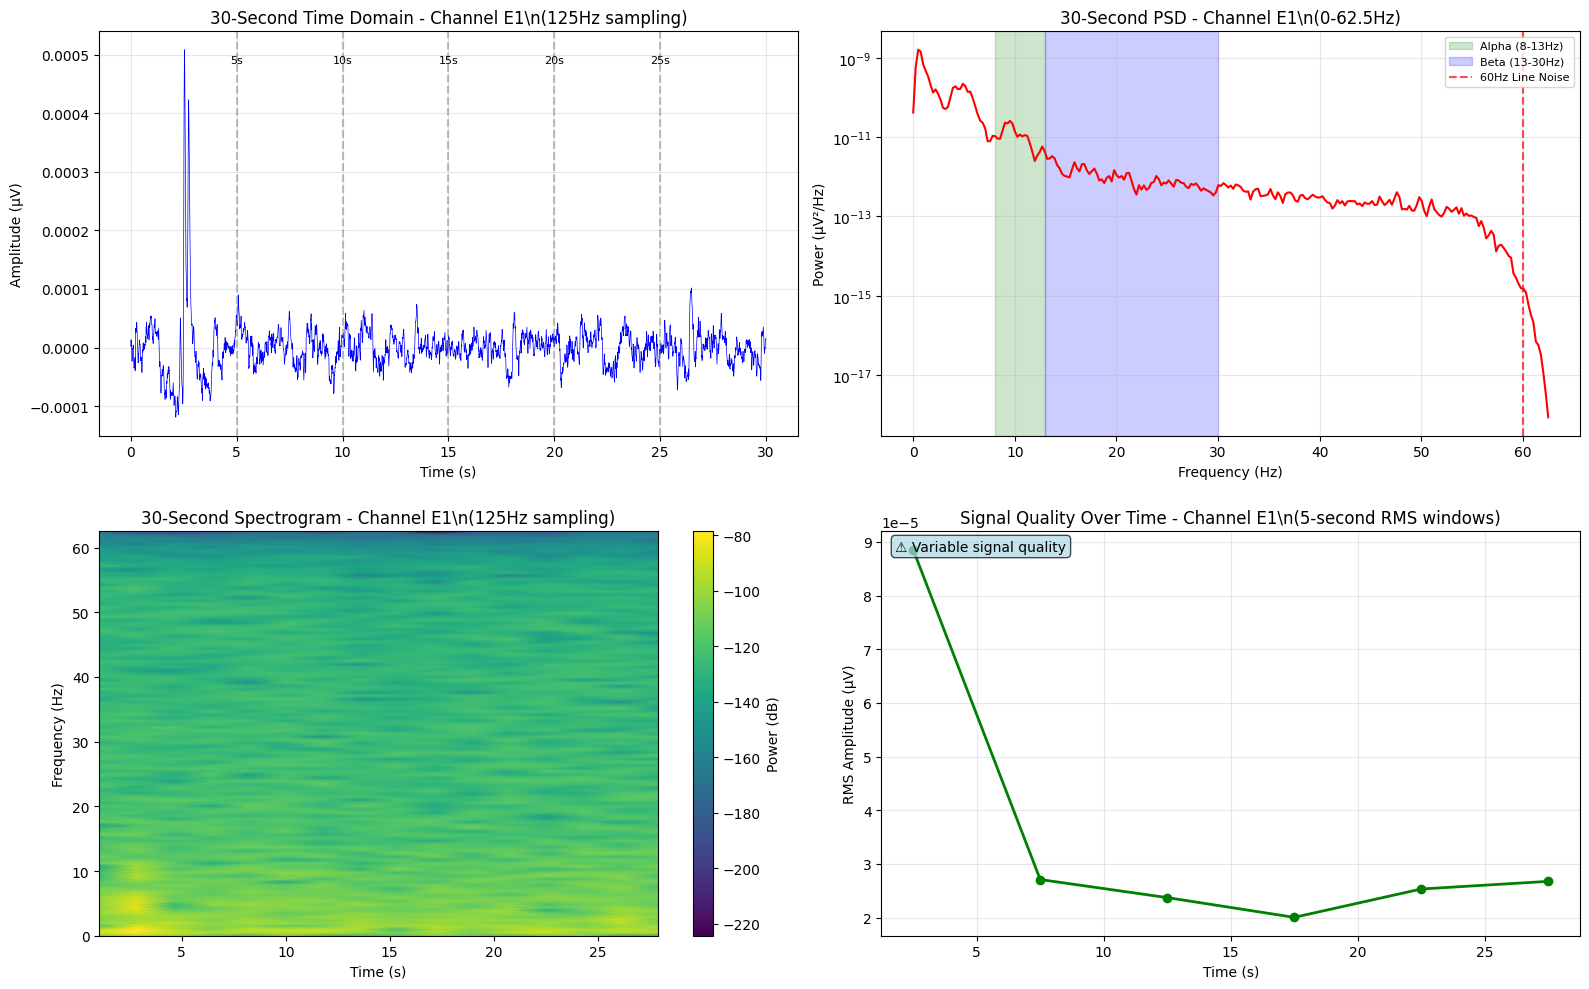

30-second analysis results:
  Peak frequency: 0.5 Hz
  Total power: 1.98e-09
  RMS amplitude: 0.0000
  Signal variance: 0.000000
  Alpha band power (8-13Hz): 5.57e-11
  Beta band power (13-30Hz): 1.72e-11

COMPREHENSIVE SPOT-CHECK COMPLETE
✅ Review the visualizations above to verify:
  1. Grayscale images show clear EEG patterns (2s windows)
  2. PSD shows expected frequency content (multiple channels)
  3. Line noise (60Hz, 120Hz) is appropriately suppressed
  4. Neural frequency bands (alpha, beta) are preserved
  5. 30-second grayscale shows longer-term EEG structure
  6. 30-second single-channel analysis reveals temporal stability


{'normalized_2sec': array([[78, 77, 77, ..., 71, 71, 71],
        [75, 72, 72, ..., 72, 68, 71],
        [63, 62, 63, ..., 67, 67, 69],
        ...,
        [44, 44, 43, ..., 96, 84, 83],
        [56, 57, 56, ..., 69, 64, 67],
        [57, 57, 57, ..., 57, 57, 57]], dtype=uint8),
 'freqs_2sec': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.]),
 'psd_2sec': array([3.99538974e-11, 9.11743154e-11, 1.91024413e-11, 8.43704686e-12,
        1.27051341e-11, 1.47603408e-11, 4.67199696e-12, 2.70137120e-12,
        8.03454003e-12, 5.99833822e-12, 5.94079562e-12, 5.38412134e-12,
        2.02998011e-12, 1.24013948e-12, 1.60473297e-12, 6.30437484e-13,
        3.06901978e-13, 1.05215895e-12, 1.487804

In [15]:
# Quick spot-check (runs all visualizations):
spot_check_preprocessing(results, recording_idx=0)